# **INSURANCE ANALITYCS: TRAVEL INSURANCE CLAIM**

**CREATED BY: PRIMA ADE SUKRONO**

## **BUSINESS PROBLEM UNDERSTANDING**

<u>**Context**</u>

Asuransi perjalanan adalah jenis asuransi yang memberikan perlindungan selama kita bepergian, baik di dalam negeri maupun luar negeri. Beberapa negara bahkan mewajibkan wisatawan untuk memiliki asuransi perjalanan, misalnya negara-negara di Eropa dan Amerika. Besarnya premi bergantung pada cakupan yang diinginkan, lama perjalanan, dan tujuan perjalanan. Perusahaan asuransi perjalanan ingin mengetahui pemegang polis yang akan mengajukan klaim asuransi. Data pemegang polis di perusahaan asuransi merupakan data historis yang terdiri dari destinasi, produk asuransi, dan sebagainya.

Target:
- 0: Tidak mengajukan claim (No)
- 1: Mengajukan claim (Yes)

---

<u>**Problem Statement**</u>

Prediksi risiko secara manual masih dapat dilakukan oleh tim Underwriting, namun proses ini cenderung memakan waktu lebih lama dan memiliki potensi kesalahan yang lebih tinggi. Keterbatasan dalam memproses kombinasi fitur secara kompleks secara manual dapat menyebabkan kesalahan prediksi—khususnya `False Negative`, yaitu calon nasabah dengan risiko tinggi klaim yang tidak terdeteksi.

Jika pendekatan konservatif digunakan, di mana semua calon nasabah diasumsikan akan mengajukan klaim, maka akan terjadi ketidakadilan dalam penetapan premi. Nasabah berisiko rendah diperlakukan sama dengan yang berisiko tinggi, yang dapat menurunkan minat pembelian polis baru dan mendorong nasabah loyal untuk berpindah ke kompetitor yang menawarkan skema premi lebih adil.

Untuk meningkatkan efisiensi operasional dan profitabilitas, tim Underwriting memerlukan sistem prediktif berbasis machine learning yang mampu mengidentifikasi calon nasabah dengan risiko klaim tinggi secara lebih akurat, serta memberikan wawasan terhadap faktor-faktor utama yang memengaruhi risiko tersebut. Sistem ini diharapkan mendukung implementasi strategi premi berbasis resiko (risk-based pricing), sehingga penetapan premi dapat lebih tepat sasaran, mengurangi kerugian finansial akibat klaim tak terduga, dan memperkuat daya saing perusahaan di pasar asuransi.

---

<u>**Tujuan Analisis**</u>

1. Memprediksi risiko klaim setiap calon pemegang polis berdasarkan data historis seperti durasi perjalanan, produk asuransi, tujuan perjalanan, usia, dan lainnya.
2. Mengidentifikasi faktor-faktor utama (risk drivers) yang menyebabkan nasabah cenderung mengajukan klaim, sebagai dasar untuk:
   - Penyesuaian premi individu (risk-based pricing)
   - Desain ulang produk dan strategi distribusi
   - Segmentasi pelanggan
3. Mendukung strategi penetapan harga yang adaptif dengan mempertimbangkan tingkat risiko yang diprediksi oleh model.
4. Membantu tim underwriting dan tim terkait membuat keputusan yang lebih akurat terhadap nasabah berisiko tinggi melalui rekomendasi berbasis data.

--- 

<u>**Pendekatan Analitik**</u>

Kita akan melakukan analisa dari data historis nasabah untuk mengidentifikasi pola yang membedakan antara nasabah yang mengajukan klaim dan yang tidak, lalu membangun model machine learning untuk memprediksi risiko klaim secara otomatis.

<u>**Metric Evaluasi**</u>

Sebelum menentukan metric evaluasi, kita perlu memperhitungkan kerugian dari salah memprediksi nasabah, dimana dalam kasus ini perkiraan biaya yang akan dikeluarkan karena kesalahan prediksi adalah:

- FN: Nasabah yang diprediksi tidak claim tapi sebenarnya claim -> Prediksi kerugian sebesar USD 305
- FP: Nasabah yang diprediksi claim namun pada kenyataannya tidak claim -> Prediksi kerugian sebesar USD 100

Jika dilihat dari sisi biaya yang ditimbulkan oleh kesalahan prediksi (*bukan total biaya keseluruhan*), maka kesalahan dalam **tidak mendeteksi nasabah yang sebenarnya mengajukan klaim (FN) memiliki dampak biaya yang jauh lebih besar** dibandingkan dengan salah memprediksi nasabah yang sebenarnya tidak mengajukan klaim (FP).

Berdasarkan pertimbangan tersebut, model yang dibangun akan difokuskan untuk semaksimal mungkin mendeteksi nasabah yang benar-benar akan mengajukan klaim (TP), serta meminimalkan kesalahan prediksi pada nasabah yang berisiko tinggi untuk claim (FN), tanpa sepenuhnya mengabaikan tingkat kesalahan dalam memprediksi nasabah yang tidak mengajukan claim (FP).

Oleh karena itu, metrik evaluasi utama yang akan digunakan adalah **f2_score** dengan alternatif scoringnya yaitu 'recall' dan 'precision'. Metric utama dipilih karena lebih berat ke recall dan sejalan dengan pertimbangan diatas, sedangkan scoring alternatif untuk mengukur sebaik apa nilai recall dan precision dari model yang di pilih.

## **Load Dataset**

In [72]:
# Import libraries

# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# data splitting
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as skPipeline
from imblearn.pipeline import Pipeline as imbPipeline

# cross validation
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier 
from xgboost.sklearn import XGBClassifier 

# evaluation metric
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer, fbeta_score

# Gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [73]:
# Import dataset
df_travel = pd.read_csv('data_travel_insurance.csv')

## **EXPLORATORY DATA ANALYSIS (EDA)**

### 1. Data Understanding

In [74]:
# Lihat 5 data teratas
df_travel.head()

Agency    Agency Type Distribution Channel              Product Name Gender  \
0    C2B       Airlines               Online        Annual Silver Plan      F   
1    EPX  Travel Agency               Online         Cancellation Plan    NaN   
2    JZI       Airlines               Online                Basic Plan      M   
3    EPX  Travel Agency               Online  2 way Comprehensive Plan    NaN   
4    C2B       Airlines               Online               Bronze Plan      M   

   Duration    Destination  Net Sales  Commision (in value)  Age Claim  
0       365      SINGAPORE      216.0                  54.0   57    No  
1         4       MALAYSIA       10.0                   0.0   33    No  
2        19          INDIA       22.0                   7.7   26    No  
3        20  UNITED STATES      112.0                   0.0   59    No  
4         8      SINGAPORE       16.0                   4.0   28    No

Setiap baris dalam dataset merepresentasikan satu transaksi penjualan polis asuransi perjalanan, di mana produk asuransi yang sama dapat terjual berkali-kali kepada nasabah yang berbeda atau untuk perjalanan yang berbeda.


Penjelasan setiap kolom dalam dataset:

- Agency: Nama dari agency.
- Agency Type: Jenis dari agen asuransi perjalanan.
- Distribution Channel: Channel distribusi dari agen asuransi perjalanan.
- Product Name: Nama dari produk asuransi perjalanan.
- Gender: Jenis kelamin dari pemegang polis.
- Duration: Lama waktu perjalanan. (*karena tidak disebutkan sebelumnya, maka diasumsikan ini dalam bentuk hari*)
- Destination: Tujuan perjalanan.
- Net Sales: Jumlah penjualan bersih dari polis asuransi perjalanan.
- Commission (in value): Komisi yang diterima agen dari hasil penjualan.
- Age: Umur dari pemegang polis.
- Claim: Status Claim.

Dari penjelasan kolom diatas, salah satu fitur dinilai secara domain knowledge tidak akan mempengaruhi keputusan orang untuk claim, yaitu fitur `Commission (in value)`. Dimana fitur ini hanya menggambarkan komisi untuk sang agen dari hasil penjualan poduk, tidak berhubungan erat dengan nasabah dan lebih berhubungan dengan penghasilan sang agen. Oleh karena itu kita hapus saja kolom ini.

Untuk kolom target masih berupa string ('Yes' dan 'No'), kita akan rubah ke bentuk angka biner menjadi ('Yes=1' dan 'No=0')

In [75]:
# Menghapus kolom 'Commision (in value)'
df_travel = df_travel.drop(columns=['Commision (in value)'])
display(df_travel.shape)

# Merubah string ke angka biner pada target
df_travel['Claim'] = df_travel['Claim'].map({'Yes': 1, 'No': 0})
display(df_travel['Claim'].unique())

(44328, 10)

array([0, 1])

In [76]:
# Lihat info data
df_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Age                   44328 non-null  int64  
 9   Claim                 44328 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 3.4+ MB


Total data ada 44,328 baris dan 11 kolom, dimana terlihat ada 1 kolom terdapat missing value yaitu `Gender`, dan Type data terlihat sudah sesuai dengan isi kolom.

In [77]:
# Lihat Deskripsi data
df_travel.describe(include='all')

Agency    Agency Type Distribution Channel       Product Name Gender  \
count   44328          44328                44328              44328  12681   
unique     16              2                    2                 26      2   
top       EPX  Travel Agency               Online  Cancellation Plan      M   
freq    24656          32113                43572              12979   6504   
mean      NaN            NaN                  NaN                NaN    NaN   
std       NaN            NaN                  NaN                NaN    NaN   
min       NaN            NaN                  NaN                NaN    NaN   
25%       NaN            NaN                  NaN                NaN    NaN   
50%       NaN            NaN                  NaN                NaN    NaN   
75%       NaN            NaN                  NaN                NaN    NaN   
max       NaN            NaN                  NaN                NaN    NaN   

            Duration Destination     Net Sales           Age         Claim  
count   44328.000000       44328  44328.000000  44328.000000  44328.000000  
unique           NaN         138           NaN           NaN           NaN  
top              NaN   SINGAPORE           NaN           NaN           NaN  
freq             NaN        9267           NaN           NaN           NaN  
mean       49.424292         NaN     40.550948     39.925600      0.015273  
std       109.153961         NaN     48.661970     13.954926      0.122636  
min        -1.000000         NaN   -357.500000      0.000000      0.000000  
25%         9.000000         NaN     18.000000     35.000000      0.000000  
50%        22.000000         NaN     26.500000     36.000000      0.000000  
75%        53.000000         NaN     48.000000     43.000000      0.000000  
max      4881.000000         NaN    810.000000    118.000000      1.000000

Dari hasil deskripsi data diatas, ditemukan bahwa terdapat anomali pada isi dari beberapa kolom berikut:
- Duration: Minimum hari adalah -1
- Net Sales: Minimum penjualannya -357.5
- Age: Minimumnya 0 dan Maximumnya 118

Maka perlu dilakukan pengecekan lebih lanjut pada kolom-kolom tersebut pada tahap pengecekan missing value.

In [78]:
# Lihat proporsi data
df_travel['Claim'].value_counts(normalize=True)

Claim
0    0.984727
1    0.015273
Name: proportion, dtype: float64

Proporsi data terlihat imbalance, dimana 98% data tersebar pada nasabah yang tidak claim (No), sedangkan hanya 2% persen data pada nasabah yang claim (Yes). Perlu dilakukan percobaan balancing data pada tahap imbalance treatment.

Kesimpulan dari data understanding ini adalah:
1. Setiap baris dalam dataset merepresentasikan satu transaksi penjualan polis asuransi perjalanan.
2. Terdapat 1 Kolom yang beberapa nilainya hilang, yaitu kolom `Gender`
3. Terdapat 3 kolom yang memiliki anomali pada isinya yang perlu dilakukan pengecekan lebih lanjut, yaitu kolom `Duration`, `Net Sales` dan `Age`.
4. Proporsi data terlihat imbalance, dimana 98% tersebar pada target 'No' dan hanya 2% tersebar pada target 'Yes'. Perlu dilakukan percobaan imbalance treatment untuk membandingkan performa sebelum dan setelah balancing.

### 2. Data Cleaning

#### A. Missing Value

In [79]:
# Lihat missing value dan anomali pada data
list_item = []
num_col = df_travel.select_dtypes(include='number').columns.drop('Claim')

for col in df_travel.columns.drop('Claim'):
    item = [col, df_travel[col].isna().sum(), round((df_travel[col].isna().sum()/len(df_travel[col])) * 100, 2)]
    if col in num_col:
        item.extend([df_travel[col].min(),
                    df_travel[col].median(),
                    df_travel[col].max()])
    else:
        item.extend(['Nan', 'Nan', 'Nan'])
    list_item.append(item)

df_info = pd.DataFrame(data=list_item, columns=['features', 'null', 'null_perc', 'min', 'Median', 'Max'])
df_info

features   null  null_perc    min Median    Max
0                Agency      0       0.00    Nan    Nan    Nan
1           Agency Type      0       0.00    Nan    Nan    Nan
2  Distribution Channel      0       0.00    Nan    Nan    Nan
3          Product Name      0       0.00    Nan    Nan    Nan
4                Gender  31647      71.39    Nan    Nan    Nan
5              Duration      0       0.00     -1   22.0   4881
6           Destination      0       0.00    Nan    Nan    Nan
7             Net Sales      0       0.00 -357.5   26.5  810.0
8                   Age      0       0.00      0   36.0    118

Melanjutkan hasil data understanding sebelumnya, terlihat memang ada nilai null dan anomlai pada beberapa fitur. Kita akan tangani nilai null dan anomali satu persatu.

Yang pertama, kita akan coba tangani nilai yang hilang pada fitur `Gender`.

Dari informasi diatas kita bisa persentase nilai hilangnya hampir mencapai 3/4 dari total datanya (71.39%). Jika diteliti lebih lanjut, tidak ada fitur lain yang bisa merepresentasikan fitur`Gender` ini sebagai referensi pengisiannya, dan jika kita paksakan isi dengan 'modus' atau 'unknown' akan menjadi bias dalam prediksi karena tidak ada jenis kelamin yang 'unknown' di dunia nyata.

Maka dari itu, fitur ini akan kita hapus karena selain persentase hilangnya yang begitu banyak dan susah untuk menebak isinya, fitur ini juga dirasa tidak akan berpengaruh secara signifikan terhadap keputusan nasabah untuk claim jika terjadi sesuatu dalam perjalanannya.

##### **`Gender`**

In [80]:
# Menghapus fitur Gender
df_travel = df_travel.drop(columns=['Gender'])
df_travel.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Age', 'Claim'],
      dtype='object')

Kita sudah berhasil menghapus fitur `Gender`, selanjutnya kita akan coba lihat anomali pada fitur duration.

##### **`Duration`**

In [81]:
# Melihat anomali pada data dengan Duration < 0
df_travel[df_travel['Duration'] < 0]

Agency Agency Type Distribution Channel Product Name  Duration  \
26228    JZI    Airlines               Online   Basic Plan        -1   
26494    JZI    Airlines               Online   Basic Plan        -1   

             Destination  Net Sales  Age  Claim  
26228           MALAYSIA       18.0  118      0  
26494  BRUNEI DARUSSALAM       18.0  118      0

Ternyata hanya 2 transaksi yang nilainya '-1', dimana keduanya berasal dari Agensi dan produk yang sama dan hanya dibedakan oleh tujuannya saja. Age disini juga mempunyai nilai yang anomali yaitu 118. Maka dari itu, data ini kemungkinan misstyping.

Kita akan coba lihat apakah ada kemiripan kedua data duration tersebut dengan transaksi lainnnya dengan tujuan yang sama.

In [82]:
# Mengambil data dengan agensi 'JZI' dengan tujuan 'MALAYSIA' dan 'BRUNEI DARUSSALAM'
malaysia = df_travel[(df_travel['Agency'] == 'JZI') & (df_travel['Destination'] == 'MALAYSIA')].sort_values(by='Duration').head()
brunei = df_travel[(df_travel['Agency'] == 'JZI') & (df_travel['Destination'] == 'BRUNEI DARUSSALAM')].sort_values(by='Duration').head()

# Menggabungkan kedua data untuk dilihat persamaannya
concat = pd.concat([malaysia, brunei])
concat

Agency Agency Type Distribution Channel Product Name  Duration  \
26228    JZI    Airlines               Online   Basic Plan        -1   
7359     JZI    Airlines               Online   Basic Plan         1   
38217    JZI    Airlines               Online   Basic Plan         1   
37046    JZI    Airlines               Online   Basic Plan         1   
24093    JZI    Airlines               Online   Basic Plan         1   
26494    JZI    Airlines               Online   Basic Plan        -1   
8014     JZI    Airlines               Online   Basic Plan         3   
35707    JZI    Airlines               Online   Basic Plan         3   
44231    JZI    Airlines               Online   Basic Plan         4   
6740     JZI    Airlines               Online   Basic Plan         5   

             Destination  Net Sales  Age  Claim  
26228           MALAYSIA       18.0  118      0  
7359            MALAYSIA       18.0   50      0  
38217           MALAYSIA       18.0   54      0  
37046           MALAYSIA      -18.0   47      0  
24093           MALAYSIA       18.0   42      0  
26494  BRUNEI DARUSSALAM       18.0  118      0  
8014   BRUNEI DARUSSALAM       18.0   36      0  
35707  BRUNEI DARUSSALAM       18.0   48      0  
44231  BRUNEI DARUSSALAM       18.0   43      0  
6740   BRUNEI DARUSSALAM       18.0   27      0

Untuk yang tujuannya 'MALAYSIA' datanya mirip dengan transaksi lainnya yang durasi perjalanannya 1 hari, maka dari itu kita akan ubah nilainya dari -1 ke 1.

Sedangkan tujuan 'BRUNEI DARUSSALAM' tidak ada yang durasi perjalanannya 1 hari, tapi bisa kita lihat bahwa harga penjualannya sama dari rentang 3-5 hari. Kemungkinan besar ini adalah harga bawah yang ditetapkan oleh agen/perusahaan asuransi perjalanan. Maka dari itu, agar nilainya tetap bervariasi namun tidak jauh dari nilai lainnya, kita akan rubah nilainya dari -1 ke 1.

Karena keduanya akan diubah ke nilai yang sama, maka kita akan langsung gunakan `.replace()` pada fungsi pandas.

In [83]:
# Mengganti data yang minus menjadi plus
df_travel['Duration'] = df_travel['Duration'].replace(-1, 1)
df_travel['Duration'].min()

np.int64(0)

Nlai '-1' sudah berhasil ditangani, namun nilai minimal sekarang adalah '0', kita perlu melihat apa artinya 0 ini, karena ini sebuah anomali jika nasabah membeli produk asuransi perjalanan namun tidak melakukan perjalanan.

In [84]:
# Melihat data dengan Duration = 0
df_travel[df_travel['Duration'] == 0]

Agency    Agency Type Distribution Channel  \
242      JZI       Airlines               Online   
1782     SSI       Airlines               Online   
1853     JWT       Airlines               Online   
2558     SSI       Airlines               Online   
3236     LWC  Travel Agency               Online   
3406     SSI       Airlines               Online   
3549     JZI       Airlines               Online   
3591     JZI       Airlines               Online   
3753     JWT       Airlines               Online   
4939     CWT  Travel Agency               Online   
6117     LWC  Travel Agency               Online   
6522     JWT       Airlines               Online   
7179     JWT       Airlines               Online   
8344     C2B       Airlines               Online   
8481     JZI       Airlines               Online   
8784     SSI       Airlines               Online   
9786     JWT       Airlines               Online   
10506    JWT       Airlines               Online   
12840    JWT       Airlines               Online   
12982    SSI       Airlines               Online   
14871    SSI       Airlines               Online   
16351    JWT       Airlines               Online   
21249    C2B       Airlines               Online   
21381    SSI       Airlines               Online   
21753    JZI       Airlines               Online   
22307    CWT  Travel Agency               Online   
23462    JZI       Airlines               Online   
23960    JWT       Airlines               Online   
24397    RAB       Airlines               Online   
27479    RAB       Airlines               Online   
27796    RAB       Airlines               Online   
29015    JWT       Airlines               Online   
30675    JZI       Airlines               Online   
33254    C2B       Airlines               Online   
34038    JWT       Airlines               Online   
35161    JWT       Airlines               Online   
36292    JZI       Airlines               Online   
38644    JWT       Airlines               Online   
39657    JWT       Airlines               Online   
39694    SSI       Airlines               Online   
40198    SSI       Airlines               Online   
40479    JZI       Airlines               Online   
40645    JZI       Airlines               Online   
41566    SSI       Airlines               Online   
43837    JZI       Airlines               Online   
43965    SSI       Airlines               Online   
44160    JWT       Airlines               Online   

                          Product Name  Duration        Destination  \
242                         Basic Plan         0              CHINA   
1782                  Ticket Protector         0          SINGAPORE   
1853                        Value Plan         0              INDIA   
2558                  Ticket Protector         0          SINGAPORE   
3236   Single Trip Travel Protect Gold         0              INDIA   
3406                  Ticket Protector         0          SINGAPORE   
3549                        Basic Plan         0           VIET NAM   
3591                        Basic Plan         0            MYANMAR   
3753                        Value Plan         0              INDIA   
4939   Rental Vehicle Excess Insurance         0      UNITED STATES   
6117   Single Trip Travel Protect Gold         0           MALAYSIA   
6522                        Value Plan         0              INDIA   
7179                        Value Plan         0              INDIA   
8344                       Bronze Plan         0          SINGAPORE   
8481                        Basic Plan         0            MYANMAR   
8784                  Ticket Protector         0          SINGAPORE   
9786                        Value Plan         0              INDIA   
10506                       Value Plan         0              INDIA   
12840                       Value Plan         0              INDIA   
12982                 Ticket Protector         0          SINGAPORE   
14871             

Total 47 baris data memang terlihat anomali dimana destinasi sudah ditentukan dan produk sudah terjual, namun tidak ada durasi perjalanannya.

Dari pemahaman data, nilai ini bisa saja direpresentasikan oleh produk yang dijual `Product Name`, tujuan perjalanan `Destination`, dan juga harga penjualannya `Net Sales`. Dari beberapa gabungan fitur tersebut kita bisa memperkirakan berapa hari biasanya perjalanan yang dilakukan untuk pembelian produk tersebut. Namun yang perlu diperhatikan bahwa bisa saja semua fitur tersebut sama pada rentang hari perjalanan yang ditentukan, seperti kasus sebelumnya pada tujuan 'BRUNEI DARUSSALAM'. 

Maka dari itu kita akan coba ambil rata-ratanya saja yang akan kita bulatkan sehingga bisa lebih merepresentasikan perkiraan dari rentangnya. Kita akan coba isikan nilai tersebut ke fitur Duration.

Untuk teknis pengisiannya kita akan menggunakan 'FunctionTransformer' dari library 'scikit-learn', dimana kita membuat function yang dapat mengisi nilai yang hilang dengan referensi fitur yang berkaitan. Function ini kemudian dimasukkan kedalam `FunctionTransformer` yang kemudian dimasukkan kedalam pipeline.

In [85]:
# Membuat fungsi untuk mengisi nilai 0 fitur Duration
def fill_duration(X):
    X = X.copy()

    # Buat group mean hanya dari baris yang Duration != 0dan net sales != 0
    ref_mean = (
        X[(X['Duration'] != 0) & (X['Net Sales'] != 0)]
        .groupby(['Product Name','Destination', 'Net Sales'])['Duration']
        .mean()
        .astype('int')
    )

    # Isi nilai yang null pada fitur Duration dengan group mean
    X['Duration'] = X.apply(
        lambda row: ref_mean.get((row['Product Name'], row['Destination'], row['Net Sales']), row['Duration'])
        if row['Duration'] == 0 else row['Duration'],
        axis=1
    )

    return X

In [86]:
# Membuat FunctionTransformer
duration_imputer = FunctionTransformer(fill_duration, validate=False)

# Copy file agar file original tidak terkontaminasi
df_travel_copy = df_travel.copy()

# Mencoba fungsi apakah sudah sesuai sebelum dimasukkan dalam pipeline
df_travel_copy = duration_imputer.fit_transform(df_travel)
df_travel_copy[df_travel_copy['Duration'] == 0]

Agency    Agency Type Distribution Channel  \
3236     LWC  Travel Agency               Online   
8344     C2B       Airlines               Online   
21249    C2B       Airlines               Online   

                          Product Name  Duration Destination  Net Sales  Age  \
3236   Single Trip Travel Protect Gold         0       INDIA      35.25   24   
8344                       Bronze Plan         0   SINGAPORE     -14.40   49   
21249                      Bronze Plan         0   SINGAPORE      14.40   49   

       Claim  
3236       0  
8344       0  
21249      0

Ternyata dari logika function yang sudah dibuat masih menyisakan 3 nilai null, yang berarti nilainya memang tidak tersedia pada kombinasi fitur produk, tujuan, dan penjualannya. Karena datanya sedikit dan agar tidak mempengaruhi akurasi model nantinya, maka kita hapus saja data ini dari dataframe originalnya.

In [87]:
# Menghapus data dengan durasi 0 pada product name = 'Single Trip Travel Protect Gold', dengan tujuan = 'INDIA' dan net sales = 35.25
df_travel = df_travel.drop(df_travel[(df_travel['Product Name'] == 'Single Trip Travel Protect Gold') & (df_travel['Destination'] == 'INDIA') & (df_travel['Net Sales'] == 35.25)].index)

# Menghapus data dengan durasi 0 pada product name = 'Bronze Plan', dengan tujuan = 'SINGAPORE', dan net sales = -14.40 & 14.4
df_travel = df_travel.drop(df_travel[(df_travel['Product Name'] == 'Bronze Plan') & (df_travel['Destination'] == 'SINGAPORE') & (df_travel['Net Sales'].isin([-14.4, 14.4]))].index)

In [88]:
# mencoba kembali fungsi apakah data dengan durasi 0 sudah tidak ada lagi
df_travel_copy = duration_imputer.fit_transform(df_travel)
display(df_travel_copy[df_travel_copy['Duration'] == 0], df_travel_copy.shape)
print("Jumlah `Duration` yang masih 0:", (df_travel_copy['Duration'] == 0).sum())

Empty DataFrame
Columns: [Agency, Agency Type, Distribution Channel, Product Name, Duration, Destination, Net Sales, Age, Claim]
Index: []

(44325, 9)

Jumlah `Duration` yang masih 0: 0


Terlihat sisa baris data menjadi 44,325 dari 44,328 baris sebelumnya, yang berarti data dengan durasi = 0 sisanya berhasil kita excludekan. Kita akan gunakan function ini pada pipeline nantinya agar proses imputasi bisa masuk dalam tahap machine learning yang bersih dan aman dari leakage.

Selanjutnya kita akan coba tangani anomali pada fitur `Net Sales`.

##### **`Net Sales`**

In [89]:
# melihat data dengan Net Sales < 0
display(df_travel[df_travel['Net Sales'] < 0])
display(df_travel[df_travel['Net Sales'] < 0]['Net Sales'].count())

Agency    Agency Type Distribution Channel  \
94       C2B       Airlines               Online   
116      CWT  Travel Agency               Online   
121      CWT  Travel Agency               Online   
199      EPX  Travel Agency               Online   
241      CWT  Travel Agency               Online   
...      ...            ...                  ...   
43694    EPX  Travel Agency               Online   
43743    CWT  Travel Agency               Online   
43751    EPX  Travel Agency               Online   
43858    EPX  Travel Agency               Online   
43922    CWT  Travel Agency               Online   

                          Product Name  Duration     Destination  Net Sales  \
94                  Annual Silver Plan       365       SINGAPORE    -216.75   
116    Rental Vehicle Excess Insurance       430       AUSTRALIA     -59.40   
121    Rental Vehicle Excess Insurance        77           JAPAN     -29.70   
199                  Cancellation Plan        29       HONG KONG     -12.00   
241    Rental Vehicle Excess Insurance        57       AUSTRALIA     -59.40   
...                                ...       ...             ...        ...   
43694         2 way Comprehensive Plan       140   UNITED STATES     -98.00   
43743  Rental Vehicle Excess Insurance        23        MALAYSIA     -29.70   
43751         2 way Comprehensive Plan       147           SPAIN     -68.00   
43858                Cancellation Plan        49  UNITED KINGDOM     -68.00   
43922  Rental Vehicle Excess Insurance       186       AUSTRALIA     -99.00   

       Age  Claim  
94      36      0  
116     41      0  
121     59      0  
199     36      0  
241     28      0  
...    ...    ...  
43694   29      0  
43743   29      0  
43751   36      0  
43858   36      0  
43922   34      0  

[482 rows x 9 columns]

np.int64(482)

Terdapat 482 nilai minus dari fitur ini. Kita akan coba lihat salah satu agency apakah terdapat nilai yang sama dengan nilai minus ini pada produk yang sama.

In [90]:
# Melihat penjualan produk dari agensi 'C2B' dengan nama produk 'Annual Silver Plan'
df_travel[(df_travel['Agency'] == 'C2B') & (df_travel['Product Name'] == 'Annual Silver Plan')]

Agency Agency Type Distribution Channel        Product Name  Duration  \
0        C2B    Airlines               Online  Annual Silver Plan       365   
11       C2B    Airlines               Online  Annual Silver Plan       365   
13       C2B    Airlines               Online  Annual Silver Plan       376   
53       C2B    Airlines               Online  Annual Silver Plan       366   
94       C2B    Airlines               Online  Annual Silver Plan       365   
...      ...         ...                  ...                 ...       ...   
44068    C2B    Airlines               Online  Annual Silver Plan       365   
44142    C2B    Airlines               Online  Annual Silver Plan       400   
44145    C2B    Airlines               Online  Annual Silver Plan       365   
44217    C2B    Airlines               Online  Annual Silver Plan       382   
44224    C2B    Airlines               Online  Annual Silver Plan       390   

      Destination  Net Sales  Age  Claim  
0       SINGAPORE     216.00   57      0  
11      SINGAPORE     216.00   27      0  
13      SINGAPORE     252.85   43      1  
53      SINGAPORE     216.00   37      0  
94      SINGAPORE    -216.75   36      0  
...           ...        ...  ...    ...  
44068   SINGAPORE     291.75   58      0  
44142   SINGAPORE     252.85   30      0  
44145   SINGAPORE     291.75   33      0  
44217   SINGAPORE     216.00   38      0  
44224   SINGAPORE     301.00   48      1  

[975 rows x 9 columns]

Benar saja, terlihat bahwa pada agen dan produk yang sama, Net Sales-nya juga sama. Ini mengindikasikan bahwa kemungkinan nilai minus adalah kesalahan dalam penginputan.

Maka dari itu, untuk semua nilai minus akan kita absolutkan saja supaya jadi positif, karena terlihat nilainya sudah benar hanya salah input.

In [91]:
# Mengubah nilai minus dari fitur Net Sales menjadi absolut (plus)
df_travel['Net Sales'] = df_travel['Net Sales'].abs()
display(df_travel['Net Sales'].min(), df_travel[df_travel['Net Sales']==0], df_travel[df_travel['Net Sales'] == 0]['Net Sales'].count())

np.float64(0.0)

Agency    Agency Type Distribution Channel  \
45       CWT  Travel Agency               Online   
60       CWT  Travel Agency               Online   
63       EPX  Travel Agency               Online   
75       C2B       Airlines               Online   
78       EPX  Travel Agency               Online   
...      ...            ...                  ...   
44207    EPX  Travel Agency               Online   
44213    CCR  Travel Agency              Offline   
44268    JZI       Airlines               Online   
44273    EPX  Travel Agency               Online   
44327    CWT  Travel Agency               Online   

                          Product Name  Duration           Destination  \
45     Rental Vehicle Excess Insurance        24  UNITED ARAB EMIRATES   
60     Rental Vehicle Excess Insurance        14             AUSTRALIA   
63                   Cancellation Plan       100         UNITED STATES   
75                         Silver Plan        23             SINGAPORE   
78                   Cancellation Plan        73               BELGIUM   
...                                ...       ...                   ...   
44207         2 way Comprehensive Plan       152         UNITED STATES   
44213               Comprehensive Plan        56              THAILAND   
44268                       Basic Plan         8             HONG KONG   
44273                Cancellation Plan        52           PHILIPPINES   
44327  Rental Vehicle Excess Insurance       172             SINGAPORE   

       Net Sales  Age  Claim  
45           0.0   27      0  
60           0.0   31      0  
63           0.0   37      0  
75           0.0   25      0  
78           0.0   36      0  
...          ...  ...    ...  
44207        0.0   49      0  
44213        0.0   20      0  
44268        0.0   69      0  
44273        0.0   36      0  
44327        0.0   31      0  

[1291 rows x 9 columns]

np.int64(1291)

Oke, kita sudah berhasil merubah nilai minus, tapi masih menyisakan nilai anomali yaitu 0. Dimana nilai ini terdeteksi ada 1,291 data.

Nilai ini dianggap anomali karena seharusnya produk yang sudah di beli mempunyai harga penjualan, namun harga 0 disini mengindikasikan harga penjualan tidak berhasil diinput dengan benar. Oleh karena itu, kita coba imputasi nilai 0 tersebut dengan pendekatan yang mirip dengan sebelumnya. Namun kali ini kita akan memasukkan nilai originalnya dari group yang sama, bukan rata-ratanya. Karena terlihat nilai `'Net Sales'` berkaitan dengan produk dan tujuan yang sama, maka fitur yang akan dijadikan referensi kali ini adalah `Product Name` dan `Destination`, namun hanya pada data yang nilai komisinya tidak kosong agar tidak bias.

Untuk fitur `Net Sales` yang bertipe data float, kita akan ganti nilai 0 nya menjadi Null/Nan agar lebih memudahkan dalam imputasi jika harus dilanjutkan oleh metode imputasi lain. Hal ini tidak dilakukan pada imputasi fitur `Duration` sebelumnya karena nilai Nan hanya bisa diterima oleh kolom bertipe data float.

In [92]:
# Merubah nilai 0 menjadi Nan
df_travel['Net Sales'] = df_travel['Net Sales'].replace(0, np.nan)

In [93]:
# melihat data dengan Net Sales yang null
df_travel[df_travel['Net Sales'].isnull()]

Agency    Agency Type Distribution Channel  \
45       CWT  Travel Agency               Online   
60       CWT  Travel Agency               Online   
63       EPX  Travel Agency               Online   
75       C2B       Airlines               Online   
78       EPX  Travel Agency               Online   
...      ...            ...                  ...   
44207    EPX  Travel Agency               Online   
44213    CCR  Travel Agency              Offline   
44268    JZI       Airlines               Online   
44273    EPX  Travel Agency               Online   
44327    CWT  Travel Agency               Online   

                          Product Name  Duration           Destination  \
45     Rental Vehicle Excess Insurance        24  UNITED ARAB EMIRATES   
60     Rental Vehicle Excess Insurance        14             AUSTRALIA   
63                   Cancellation Plan       100         UNITED STATES   
75                         Silver Plan        23             SINGAPORE   
78                   Cancellation Plan        73               BELGIUM   
...                                ...       ...                   ...   
44207         2 way Comprehensive Plan       152         UNITED STATES   
44213               Comprehensive Plan        56              THAILAND   
44268                       Basic Plan         8             HONG KONG   
44273                Cancellation Plan        52           PHILIPPINES   
44327  Rental Vehicle Excess Insurance       172             SINGAPORE   

       Net Sales  Age  Claim  
45           NaN   27      0  
60           NaN   31      0  
63           NaN   37      0  
75           NaN   25      0  
78           NaN   36      0  
...          ...  ...    ...  
44207        NaN   49      0  
44213        NaN   20      0  
44268        NaN   69      0  
44273        NaN   36      0  
44327        NaN   31      0  

[1291 rows x 9 columns]

In [94]:
# Mendefinisikan Fungsi untuk mengisi Net Sales yang kosong
def fill_netsales(X):
    X = X.copy()

    # Buat referensi nilai dari baris yang net salesnya tidak mengandung nilai Nan
    ref_mean = (
        X[X['Net Sales'].notnull()]
        .drop_duplicates(['Product Name', 'Destination'])
        .set_index(['Product Name', 'Destination'])['Net Sales']
        .to_dict()
    )

    # Isi nilai Net Sales yang null dengan referensi dari group produk dan tujuan
    X['Net Sales'] = X.apply(
        lambda row: ref_mean.get((row['Product Name'], row['Destination']), row['Net Sales'])
        if pd.isnull(row['Net Sales']) else row['Net Sales'],
        axis=1
    )

    return X

In [95]:
# Membuat FunctionTransformer
netsales_imputer = FunctionTransformer(fill_netsales, validate=False)

# Mencoba fungsi apakah data yang hilang pada fitur Net Sales sudah tidak ada lagi
df_travel_copy = netsales_imputer.fit_transform(df_travel)

display(df_travel_copy[df_travel_copy['Net Sales'].isnull()])
print("Jumlah `Net Sales` yang masih Nan:", df_travel_copy['Net Sales'].isnull().sum())

Agency    Agency Type Distribution Channel  \
7128     LWC  Travel Agency               Online   
13098    EPX  Travel Agency               Online   
17786    CWT  Travel Agency               Online   
17879    TST  Travel Agency              Offline   
18028    CWT  Travel Agency               Online   
26917    CWT  Travel Agency               Online   
27058    LWC  Travel Agency               Online   
33127    JZI       Airlines               Online   
38534    EPX  Travel Agency               Online   

                              Product Name  Duration         Destination  \
7128   Single Trip Travel Protect Platinum         2              ANGOLA   
13098             1 way Comprehensive Plan         8             BAHRAIN   
17786      Rental Vehicle Excess Insurance        14  RUSSIAN FEDERATION   
17879         Travel Cruise Protect Family        30            MALAYSIA   
18028      Rental Vehicle Excess Insurance         7              LATVIA   
26917      Rental Vehicle Excess Insurance         2          AZERBAIJAN   
27058    Single Trip Travel Protect Silver        12           ARGENTINA   
33127                           Value Plan         7               MACAO   
38534             1 way Comprehensive Plan        79               EGYPT   

       Net Sales  Age  Claim  
7128         NaN   19      0  
13098        NaN   36      0  
17786        NaN   36      0  
17879        NaN   32      0  
18028        NaN   43      0  
26917        NaN   31      0  
27058        NaN   28      0  
33127        NaN   40      0  
38534        NaN   36      0

Jumlah `Net Sales` yang masih Nan: 9


Terlihat masih ada nilai 0 sebanyak 9 baris. Kita akan imput sisa nilai null ini menggunakan `Iterative Imputer` pada tahap selanjutnya setelah imputasi menggunakan `FunctionTransformer` di pipeline nantinya.

Selanjutnya kita akan tangani missing value pada fitur `Age`.

##### **`Age`**

In [96]:
# Lihat data dengan 'Age' = 0
df_travel[df_travel['Age']==0]

Agency    Agency Type Distribution Channel           Product Name  \
37815    TST  Travel Agency              Offline  Travel Cruise Protect   
44319    TST  Travel Agency              Offline  Travel Cruise Protect   

       Duration Destination  Net Sales  Age  Claim  
37815        94    THAILAND       30.0    0      0  
44319        94    THAILAND       30.0    0      0

Ternyata hanya 2 data dengan umur = 0, dimana produk yang terjual sama dari agen yang sama dengan durasi dan tujuan yang sama. Kita akan coba lihat data lain dari keempat fitur yang sama tersebut untuk melihat transaksi ini hanya terjadi 2 kali ini saja atau ada data lain yang umurnya tidak 0.

In [97]:
# Cek nilai pada Agen, produk, durasi, dan tujuan yang sama dengan 'Age' = 0
df_travel[(df_travel['Agency']=='TST') & (df_travel['Product Name'] == 'Travel Cruise Protect') & (df_travel['Duration']==94) & (df_travel['Destination'] == 'THAILAND')]

Agency    Agency Type Distribution Channel           Product Name  \
19990    TST  Travel Agency              Offline  Travel Cruise Protect   
28019    TST  Travel Agency              Offline  Travel Cruise Protect   
29047    TST  Travel Agency              Offline  Travel Cruise Protect   
29896    TST  Travel Agency              Offline  Travel Cruise Protect   
31105    TST  Travel Agency              Offline  Travel Cruise Protect   
37815    TST  Travel Agency              Offline  Travel Cruise Protect   
44319    TST  Travel Agency              Offline  Travel Cruise Protect   

       Duration Destination  Net Sales  Age  Claim  
19990        94    THAILAND       30.0   52      0  
28019        94    THAILAND       30.0   55      0  
29047        94    THAILAND       30.0   55      0  
29896        94    THAILAND       30.0   48      0  
31105        94    THAILAND       30.0   35      0  
37815        94    THAILAND       30.0    0      0  
44319        94    THAILAND       30.0    0      0

Ternyata ada transaksi lain pada fitur-fitur yang sama tersebut. Dapat kita simpulkan bahwa nilai 0 ini kemungkinan besar adalah salah input / error / umur memang tidak diketahui pada saat input. Maka dari itu kita akan coba input nilainya dengan rata-rata umur dari transaksi yang sama tersebut, agar data semakin bervariasi namun masih dalam rentang umur pada transaksi yang sama.

Karena datanya hanya 2, maka akan kita imput langsung saja tidak menggunakan pipeline, karena dampaknya tidak akan terlalu besar untuk model jika terjadi kebocoran informasi data.

In [98]:
# Referensi rata-rata umur dari Agen, Produk, Durasi, dan Destination yang sama (tanpa umur 0)
ref_mean_age = df_travel[(df_travel['Agency'] == 'TST') 
                         & (df_travel['Product Name'] == 'Travel Cruise Protect') 
                         & (df_travel['Duration']==94) 
                         & (df_travel['Destination'] == 'THAILAND') 
                         & (df_travel['Age'] != 0)]['Age'].mean()

# Mengisi nilai 0 dengan rata-rata umurnya
df_travel.loc[(df_travel['Agency'] == 'TST') 
              & (df_travel['Product Name'] == 'Travel Cruise Protect') 
              & (df_travel['Duration']==94) & (df_travel['Destination'] == 'THAILAND') 
              & (df_travel['Age'] == 0), 'Age'] = ref_mean_age

# Cek sekali lagi untuk umur = 0
print(f'Jumlah data pada fitur umur yang masih 0: {df_travel[df_travel["Age"] == 0].shape[0]}')

Jumlah data pada fitur umur yang masih 0: 0


Kita sudah berhasil mengganti nilai 0 pada `Age`. 

Proses deteksi missing value dan cara-cara pengisiannya sudah selesai dan ditentukan, maka kesimpulan dari tahap ini adalah:

- Terdapat nilai null pada fitur `Gender` dengan persentase 71.39% dari total data di fitur tersebut, sehingga kita putuskan untuk menghapusnya.
- Terdapat nilai yang anomali pada 3 fitur numerik yaitu `Duration`, `Net Sales`, dan `Age`. Nilai anomali tersebut kita perlakukan sebagai missing value, dimana nilainya kita ganti menjadi nilai yang lebih wajar.
- Nilai anomali pada fitur `Duration` berupa angka minus dan nol (0). Nilai negatifnya berhasil kita rubah menjadi nilai positif dan nilai nolnya (0) kita buatkan `FunctionTransformer` yang proses pengisiannya nanti akan dimasukkan ke dalam tahapan pipeline. Sedangkan untuk 3 baris sisa data 0 kita hapus karena tidak ditemukan kemiripan dengan transaksi lain, dan karena hanya sedikit sehingga tidak akan berpengaruh signifikan pada model nantinya.
- Hal yang sama juga kita lakukan pada fitur `Net Sales` karena terdapat nilai anomali yang mirip dengan `Duration`. Namun nilai nol disini terlebih dahulu kita rubah menjadi Nan karena tipe data ini adalah float, dan nilai yang akan diisikan adalah nilai aktual hasil dari kombinasi fitur `Product Name` dan `Destination`. Pengisiannya melibatkan 2 tahapan pada pipeline nantinya, yaitu `FunctionTransformer` yang sudah dibuat, dan juga `IterativeImputer` untuk sisa nilai Nan-nya. Tidak ada baris data yang kita hapus disini.
- Sedangkan untuk fitur `Age` hanya terdapat nilai anomali berupa (0), jadi kita ganti saja nilai 0 ke nilai yang wajarnya. Dimana nilainya kita ganti dengan rata-ratanya pada setiap transaksi yang sama.

#### B. Outliers

Kita akan coba cek outlier pada semua numerical data dengan menggunakan data copy yang sebelumnya dibuat karena data ini menggambarkan skenario setelah imputasi nantinya.

In [99]:
# Mengambil semua kolom numerical
df_travel_numeric = df_travel_copy.select_dtypes(include='number').drop(columns='Claim')
df_travel_numeric

Duration  Net Sales  Age
0           365      216.0   57
1             4       10.0   33
2            19       22.0   26
3            20      112.0   59
4             8       16.0   28
...         ...        ...  ...
44323        14       30.0   36
44324        17       79.2   47
44325        64       30.0   50
44326        51       36.0   36
44327       172       39.6   31

[44325 rows x 3 columns]

In [100]:
# Membuat visualisasi boxplot untuk melihat outlier dengan plotly
from plotly.subplots import make_subplots

# Membuat subplots
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=[col for col in df_travel_numeric.columns])
row_col = [(1, 1), (1, 2), (2, 1), (2, 2)]

# Membuat grafik dengan looping
for i, col in enumerate(df_travel_numeric.columns):    
    box = px.box(df_travel_copy, x='Claim', y=col)
    for trace in box.data:
        fig.add_trace(trace, row=row_col[i][0], col=row_col[i][1])

# Update layout dan tampilkan grafik dalam sublots
fig.update_layout(title_text='Outlier Pada Masing-masing Fitur',
                  title_x = 0.5,
                  title_font_size = 20,
                  width=1100, height=800)
fig.show()

Terlihat dari visualisasi disemua fitur numerik terdapat outlier. Namun, yang tampak memiliki benar-benar outlier extrem ada pada fitur `Duration` dan `Age`, dimana nilainya diluar jauh dari rentang nilai wajarnya. 

Untuk `Net Sales` sepertinya terlihat masih wajar rentangnya, sedangkan `Commision (in value)` memang masih terdapat nilai 0 yang banyak pada datanya jadi nilai lainnya terlihat seperti outlier dan distribusi datanya tidak menggambarkan distribusi data sebenarnya. Fitur `Commission (in value)` ini masih dalam pertimbangan untuk di hapus.

Kita coba lihat lebih dalam pada fitur `Duration` terlebih dahulu.

##### **`Duration`**

Terlihat dari grafik, outlier ini berada pada durasi diatas 4500 hari, maka dari itu kita akan cobna melihat apakah perjalanan dengan durasi diatas 4500 dipengaruhi oleh fitur lain atau tidak.

In [101]:
# Melihat data dengan durasi > 4500
display(df_travel_copy[df_travel_copy['Duration'] > 4500])
print(f'Jumlah outlier pada durasi > 4500: {df_travel_copy[df_travel_copy["Duration"] > 4500].shape[0]}')

Agency Agency Type Distribution Channel      Product Name  Duration  \
87       SSI    Airlines               Online  Ticket Protector      4736   
4678     SSI    Airlines               Online  Ticket Protector      4857   
10172    SSI    Airlines               Online  Ticket Protector      4815   
12140    SSI    Airlines               Online  Ticket Protector      4652   
19497    SSI    Airlines               Online  Ticket Protector      4881   
20038    SSI    Airlines               Online  Ticket Protector      4844   
22215    SSI    Airlines               Online  Ticket Protector      4580   
25606    SSI    Airlines               Online  Ticket Protector      4685   
28032    SSI    Airlines               Online  Ticket Protector      4829   
37207    SSI    Airlines               Online  Ticket Protector      4609   
38536    SSI    Airlines               Online  Ticket Protector      4784   
42584    SSI    Airlines               Online  Ticket Protector      4831   
42717    SSI    Airlines               Online  Ticket Protector      4847   

      Destination  Net Sales  Age  Claim  
87      SINGAPORE       0.32   48      0  
4678    SINGAPORE       0.32   48      0  
10172   SINGAPORE       0.32   48      0  
12140   SINGAPORE       0.32   48      0  
19497   SINGAPORE       0.13   48      0  
20038   SINGAPORE       0.32   48      0  
22215   SINGAPORE       0.32   48      0  
25606   SINGAPORE       0.32   48      0  
28032   SINGAPORE       0.32   48      0  
37207   SINGAPORE       0.32   48      0  
38536   SINGAPORE       0.32   48      0  
42584   SINGAPORE       0.32   48      0  
42717   SINGAPORE       0.32   48      0

Jumlah outlier pada durasi > 4500: 13


In [102]:
# Melihat di data asli dengan durasi perjalanan ini apakah Net Sales nya 0
df_travel[(df_travel['Duration']>4500) & (df_travel['Net Sales'] == 0)]

Empty DataFrame
Columns: [Agency, Agency Type, Distribution Channel, Product Name, Duration, Destination, Net Sales, Age, Claim]
Index: []

Terlihat bahwa transaksi dengan durasi perjalanan extrem ini terjadi pada pembelian produk yang sama, dengan agency yang sama dan tujuan yang sama, juga pada umur nasabah yang sama. Transaksi ini juga memiliki nilai pada net salesnya, yang artinya transaksi ini mungkin benar di beli dengan harga yang sesuai, namun tidak dapat diketahui pasti apakah ini benar-benar transaksi yang nyata dan hanya misstyping dalam penginputannya ataukah terinput beberapa kali untuk transaksi yang sama..

Kita akan coba lihat transaksi yang serupa pada Agensi, produk, tujuan, dan harga yang sama, namun pada durasi perjalanan yang umum untuk perbandingan.

In [103]:
# Melihat kesamaan transaksi pada produk, agen, dan tujuan yang sama
duration_outlier = df_travel_copy[(df_travel_copy['Agency']=='SSI')
                                  & (df_travel_copy['Product Name'] == 'Ticket Protector') 
                                  & (df_travel_copy['Destination'] == 'SINGAPORE')]

duration_outlier

Agency Agency Type Distribution Channel      Product Name  Duration  \
87       SSI    Airlines               Online  Ticket Protector      4736   
159      SSI    Airlines               Online  Ticket Protector        36   
186      SSI    Airlines               Online  Ticket Protector        97   
200      SSI    Airlines               Online  Ticket Protector        45   
262      SSI    Airlines               Online  Ticket Protector       146   
...      ...         ...                  ...               ...       ...   
44128    SSI    Airlines               Online  Ticket Protector         5   
44130    SSI    Airlines               Online  Ticket Protector        95   
44143    SSI    Airlines               Online  Ticket Protector        28   
44235    SSI    Airlines               Online  Ticket Protector        60   
44262    SSI    Airlines               Online  Ticket Protector       223   

      Destination  Net Sales  Age  Claim  
87      SINGAPORE       0.32   48      0  
159     SINGAPORE       3.73   48      0  
186     SINGAPORE       5.59   48      0  
200     SINGAPORE       1.03   48      0  
262     SINGAPORE       0.19   48      0  
...           ...        ...  ...    ...  
44128   SINGAPORE       1.13   48      0  
44130   SINGAPORE      11.70   48      0  
44143   SINGAPORE       4.19   48      0  
44235   SINGAPORE       4.38   48      0  
44262   SINGAPORE      16.54   48      0  

[765 rows x 9 columns]

In [104]:
# Melihat nili unique dari Age untuk transaksi yang sama diatas
duration_outlier['Age'].unique()

array([ 48, 118])

Sebenarnya penjualan pada produk 'ticket protector' dari agen 'SSI' ini beragam, namun hanya pada nasabah yang berumur 48 dan 118 tahun. kita akan coba melihat transaksi ini pada harga yang sama.

In [105]:
duration_outlier[duration_outlier['Net Sales'] == 0.32]

Agency Agency Type Distribution Channel      Product Name  Duration  \
87       SSI    Airlines               Online  Ticket Protector      4736   
4678     SSI    Airlines               Online  Ticket Protector      4857   
10172    SSI    Airlines               Online  Ticket Protector      4815   
12140    SSI    Airlines               Online  Ticket Protector      4652   
16872    SSI    Airlines              Offline  Ticket Protector         1   
20038    SSI    Airlines               Online  Ticket Protector      4844   
22215    SSI    Airlines               Online  Ticket Protector      4580   
25606    SSI    Airlines               Online  Ticket Protector      4685   
27921    SSI    Airlines              Offline  Ticket Protector         1   
28032    SSI    Airlines               Online  Ticket Protector      4829   
34287    SSI    Airlines              Offline  Ticket Protector         1   
37207    SSI    Airlines               Online  Ticket Protector      4609   
38536    SSI    Airlines               Online  Ticket Protector      4784   
42584    SSI    Airlines               Online  Ticket Protector      4831   
42717    SSI    Airlines               Online  Ticket Protector      4847   

      Destination  Net Sales  Age  Claim  
87      SINGAPORE       0.32   48      0  
4678    SINGAPORE       0.32   48      0  
10172   SINGAPORE       0.32   48      0  
12140   SINGAPORE       0.32   48      0  
16872   SINGAPORE       0.32  118      0  
20038   SINGAPORE       0.32   48      0  
22215   SINGAPORE       0.32   48      0  
25606   SINGAPORE       0.32   48      0  
27921   SINGAPORE       0.32  118      0  
28032   SINGAPORE       0.32   48      0  
34287   SINGAPORE       0.32  118      0  
37207   SINGAPORE       0.32   48      0  
38536   SINGAPORE       0.32   48      0  
42584   SINGAPORE       0.32   48      0  
42717   SINGAPORE       0.32   48      0

Transaksi ini terlihat aneh, dimana dari semua transaksi yang dilakukan dengan harga tersebut memiliki 2 anomali berbeda, entah itu di durasinya atau umur nasabahnya. Jika dilihat pada transaksi dengan harga berbeda sebelumnya, ada transaksi dengan harga diatas transaksi outlier ini namun durasi perjalanannya masih masuk akal.

Karena nilai outlier pada durasi ini sangat jauh, dan tidak ada yang bisa menggambarkan bahwa transaksi ini sebenarnya mirip dengan transaksi lainnya yang bukan outlier, ditambah data dari outlier ini yang terlihat sedikit, maka kita akan mengahapus saja nilainya.

In [106]:
# Membuang outlier pada data original dan copy dengan durasi > 4500
df_travel = df_travel[df_travel['Duration'] < 4500]
df_travel_copy = df_travel_copy[df_travel_copy['Duration'] < 4500]   # Untuk visualisasi

# Melihat jumlah data setelah di exclude nilai durasi > 4500
print(f'Jumlah outlier pada data setelah di exclude nilai durasi > 4500: {df_travel[df_travel["Duration"] > 4500].shape[0]}')
print(f'Sisa jumlah data: {df_travel.shape[0]}')

Jumlah outlier pada data setelah di exclude nilai durasi > 4500: 0
Sisa jumlah data: 44312


In [107]:
duration_bar = px.box(df_travel_copy, x='Claim', y='Duration')

duration_bar.update_layout(title_text='Outlier pada Durasi',
                           title_x = 0.5,
                           title_font_size = 20,)
duration_bar.show()

Outlier extrem sudah berhasil ditangani, namun terlihat masih ada 1 outlier yang cukup jauh dari distribusi datanya yang lain. Kita akan coba cek lebih lanjut apakah nilai ini bisa kita anggap wajar atau tidak pada transaksi dengan produk dan tujuan yang sama.

In [108]:
# Melihat transaksi yang dicurigai juga outlier, yaitu durasi diatas 700 hari
df_travel_copy[df_travel_copy['Duration'] > 700]

Agency Agency Type Distribution Channel        Product Name  Duration  \
21551    C2B    Airlines               Online  Annual Silver Plan       740   

      Destination  Net Sales  Age  Claim  
21551   SINGAPORE      216.0   36      0

In [109]:
# Melihat transaksi yang produk dan tujuannya sama dengan yang di curigai outlier
display(df_travel_copy[(df_travel_copy['Product Name'] == 'Annual Silver Plan') 
                       & (df_travel_copy['Destination'] == 'SINGAPORE')].sort_values(by='Duration', ascending=False))

Agency Agency Type Distribution Channel        Product Name  Duration  \
21551    C2B    Airlines               Online  Annual Silver Plan       740   
17756    C2B    Airlines               Online  Annual Silver Plan       547   
37062    C2B    Airlines               Online  Annual Silver Plan       529   
33614    C2B    Airlines               Online  Annual Silver Plan       519   
8905     C2B    Airlines               Online  Annual Silver Plan       497   
...      ...         ...                  ...                 ...       ...   
6018     C2B    Airlines               Online  Annual Silver Plan       364   
31034    C2B    Airlines               Online  Annual Silver Plan       364   
31103    C2B    Airlines               Online  Annual Silver Plan       364   
39802    C2B    Airlines               Online  Annual Silver Plan       364   
33958    C2B    Airlines               Online  Annual Silver Plan       364   

      Destination  Net Sales  Age  Claim  
21551   SINGAPORE     216.00   36      0  
17756   SINGAPORE     252.85   33      0  
37062   SINGAPORE     216.00   68      0  
33614   SINGAPORE     216.00   60      0  
8905    SINGAPORE     259.20   61      0  
...           ...        ...  ...    ...  
6018    SINGAPORE     161.00   41      0  
31034   SINGAPORE     187.85   34      0  
31103   SINGAPORE     216.00   49      0  
39802   SINGAPORE     252.85   41      0  
33958   SINGAPORE     252.85   41      1  

[975 rows x 9 columns]

Nilai durasi hari 740 ini hanya terdeteksi ada 1 data dan terlihat cukup jauh beda harinya dengan nilai di bawahnya. Karena hanya 1 data, kita hapus saja outlier ini dan kita tetapkan 547 sebagai batas atasnya karena masih dalam rentang yang wajar.

In [110]:
# Membuang outlier pada data original dan copy dengan durasi > 600
df_travel = df_travel[df_travel['Duration'] < 600]
df_travel_copy = df_travel_copy[df_travel_copy['Duration'] < 600]   # Untuk visualisasi

# Melihat jumlah data setelah di exclude nilai durasi > 600
print(f'Jumlah outlier pada data setelah di exclude nilai durasi > 600: {df_travel[df_travel["Duration"] > 600].shape[0]}')
print(f'Sisa jumlah data: {df_travel.shape[0]}')

Jumlah outlier pada data setelah di exclude nilai durasi > 600: 0
Sisa jumlah data: 44311


In [111]:
duration_bar = px.box(df_travel_copy, x='Claim', y='Duration')

duration_bar.update_layout(title_text='Outlier pada Durasi',
                           title_x = 0.5,
                           title_font_size = 20,)
duration_bar.show()

Oke, sekarang datanya sudah cukup bersih, meskipun ada outlier namun masih pada rentang yang wajar sejauh ini.

Kita akan lanjut analisa pada fitur `Net Sales`.

##### **`Net Sales`**

In [112]:
px.box(df_travel_copy, x='Claim', y='Net Sales', title='Outlier pada Net Sales')

In [113]:
# Melihat outlier yang nilai Net Sales-nya berada di atas 500
netsales_outlier = df_travel_copy[df_travel_copy['Net Sales'] > 500]
netsales_outlier.sort_values(by='Net Sales', ascending=False)

Agency Agency Type Distribution Channel      Product Name  Duration  \
42971    JZI    Airlines               Online        Value Plan       139   
16075    C2B    Airlines               Online       Bronze Plan       179   
2810     C2B    Airlines               Online  Annual Gold Plan       364   
4793     C2B    Airlines               Online  Annual Gold Plan       383   
13901    C2B    Airlines               Online  Annual Gold Plan       366   
32765    C2B    Airlines               Online  Annual Gold Plan       366   
9032     C2B    Airlines               Online       Bronze Plan       154   
6105     C2B    Airlines               Online         Gold Plan       173   
18334    C2B    Airlines               Online         Gold Plan       175   
15375    C2B    Airlines               Online         Gold Plan       172   
7510     C2B    Airlines               Online  Annual Gold Plan       370   
19206    C2B    Airlines               Online       Silver Plan        95   
32531    C2B    Airlines               Online       Silver Plan        90   

         Destination  Net Sales  Age  Claim  
42971  UNITED STATES      810.0  118      0  
16075      SINGAPORE      682.0   25      0  
2810       SINGAPORE      666.0   31      0  
4793       SINGAPORE      599.0   34      0  
13901      SINGAPORE      599.0   72      0  
32765      SINGAPORE      599.0   37      0  
9032       SINGAPORE      586.0   36      0  
6105       SINGAPORE      572.5   40      0  
18334      SINGAPORE      539.0   24      0  
15375      SINGAPORE      515.0   24      0  
7510       SINGAPORE      511.0   39      0  
19206      SINGAPORE      507.0   74      0  
32531      SINGAPORE      507.0   32      1

Jika melihat secara keseluruhan data dari Net Sales diatas 500 yang dianggap outlier, nilai tinggi tersebut didukung oleh produk yang sepertinya premium atau produk non premium namun durasi perjalanannya tinggi, dan juga ke negara-negara tertentu seperti Amerika dan Singapura yang mungkin memang biayanya tinggi.

Sehingga outlier ini akan kita biarkan saja, karena sesuai konteks bisnis nilainya masih masuk akal.

Selanjutnya kita akan coba melihat outlier pada fitur `Age`.

##### **`Age`**

Pada fitur Age ini terlihat ada 2 data yang nilainya jauh dengan yang lainnya, dimana data ini juga diluar rentang umur yang wajar. Kita akan coba cek data extreme outlier tersebut.

In [114]:
px.box(df_travel_copy, x='Claim', y='Age', title='Outlier pada Age')

In [115]:
# Melihat outlier pada fitur Age yang nilainya 118
df_travel_copy[df_travel_copy['Age']==118]

Agency Agency Type Distribution Channel Product Name  Duration  \
99       ART    Airlines               Online   Value Plan         7   
105      JZI    Airlines              Offline   Basic Plan        16   
363      JWT    Airlines               Online   Value Plan        12   
373      JWT    Airlines               Online   Value Plan         6   
727      JWT    Airlines               Online   Value Plan        76   
...      ...         ...                  ...          ...       ...   
44089    JWT    Airlines               Online   Value Plan        42   
44140    JWT    Airlines               Online   Value Plan        84   
44150    JWT    Airlines               Online   Value Plan         5   
44160    JWT    Airlines               Online   Value Plan         0   
44219    JWT    Airlines               Online   Value Plan         5   

      Destination  Net Sales  Age  Claim  
99       MALAYSIA       29.0  118      0  
105     INDONESIA       37.0  118      0  
363         INDIA       39.0  118      0  
373         INDIA       39.0  118      0  
727         INDIA      100.0  118      0  
...           ...        ...  ...    ...  
44089       INDIA       31.0  118      0  
44140       INDIA       93.0  118      0  
44150       INDIA       39.0  118      0  
44160       INDIA       31.0  118      0  
44219       INDIA       31.0  118      0  

[676 rows x 9 columns]

Datanya terlihat sangat beragam pada transaksi yang umur nasabahnya 118, namun angka ini mengindikasikan adanya ketidaksesuaian input, dimana angkanya konstant pada transaksi yang berbeda, nilai ini seperti missing value.

Maka dari itu, kita akan treatment nilai ini sebagai missing value, dimana terlebih dahulu nilainya kita rubah menjadi Nan baru kemudian kita akan imputasi menggunakan `FunctionTransformer` seperti cara sebelumnya, dan kemudian menggunakan `Iterative Imputer` jika masih menyisakan null.

In [116]:
# Membuat fungsi untuk mengisi nilai 118 pada fitur Age
def fill_age(X):
    X = X.copy()
    X['Age'].astype('float')
    X['Age'] = X['Age'].replace(118, np.nan)

    # Buat group mean hanya dari baris yang Net Sales != 0
    ref_mean = (
        X[X['Net Sales'] != 0]
        .groupby(['Product Name', 'Net Sales'])['Age']
        .mean()
    )

    # Isi nilai yang null pada fitur Duration dengan group mean
    X['Age'] = X.apply(
        lambda row: ref_mean.get((row['Product Name'], row['Net Sales']), row['Age'])
        if pd.isna(row['Age']) else row['Age'],
        axis=1
    )
    
    return X

In [117]:
# Membuat FunctionTransformer
age_imputer = FunctionTransformer(fill_age, validate=False)

# Mencoba fungsi apakah sudah sesuai sebelum dimasukkan dalam pipeline
df_travel_copy = age_imputer.fit_transform(df_travel)
df_travel_copy[df_travel_copy['Age'].isnull()]

Agency Agency Type Distribution Channel Product Name  Duration  \
727      JWT    Airlines               Online   Value Plan        76   
873      ART    Airlines               Online   Value Plan       137   
911      JWT    Airlines               Online   Value Plan        11   
1130     JWT    Airlines               Online   Value Plan         6   
1379     ART    Airlines               Online   Value Plan        15   
...      ...         ...                  ...          ...       ...   
43349    JZI    Airlines               Online   Basic Plan        12   
43433    ART    Airlines               Online   Value Plan         8   
43838    JWT    Airlines               Online   Value Plan        67   
43928    JWT    Airlines               Online   Value Plan        83   
44140    JWT    Airlines               Online   Value Plan        84   

      Destination  Net Sales  Age  Claim  
727         INDIA      100.0  NaN      0  
873     HONG KONG       61.0  NaN      0  
911         INDIA       60.0  NaN      0  
1130        INDIA       62.0  NaN      0  
1379        CHINA       61.0  NaN      0  
...           ...        ...  ...    ...  
43349      CANADA       64.0  NaN      0  
43433    THAILAND       34.0  NaN      0  
43838       INDIA      200.0  NaN      0  
43928       INDIA      180.0  NaN      0  
44140       INDIA       93.0  NaN      0  

[185 rows x 9 columns]

Terlihat nilai 118 ini akan berkurang cukup signifikan setelah imputasi nantinya, dan sisanya akan diimputasi menggunakan metode iterative imputer.

Untuk tahap pengecekan dan penanganan outlier sudah selesai, dimana kesimpulan yang dapat diambil adalah:
- Ditemkan outlier pada keempat fitur numerik yaitu `Duration`, `Net Sales`, dan `Age`.
- Outlier dari fitur `Duration` yang diatas 600 hari di excludekan (hapus) dari data yang akan dipakai karena dinilai terlalu extreme dan tidak banyak datanya.
- Outlier pada fitur `Net Sales` dibiarkan saja karena dinilai masih masuk akal.
- Outlier pada fitur `Age` dimana nilainya 118 diperlakukan seperti missing value, dimana akan dilakukan imputasi menggunakan `FunctionTransformer` dan `Iterative Imputer`.

#### C. Duplicate Data

In [118]:
display(df_travel.duplicated().value_counts(), df_travel.duplicated().value_counts(normalize=True)*100)

False    38991
True      5320
Name: count, dtype: int64

False    87.993952
True     12.006048
Name: proportion, dtype: float64

Total ada 5320 data yang duplikat, dimana proporsinya adalah sebanyak 12% dari keseluruhan data. Meskipun data ini sebenarnya menggambarkan transaksi yang mungkin berbeda pada setiap barisnya, namun tidak tersedia transaksi ID yang unik yang membedakan antar transaksi, sehingga data banyak terlihat duplikat. Namun tidak ada alasan yang kuat untuk mempertahankan duplikat, jadi kita putuskan akan hapus saja duplikasi datanya.

In [119]:
df_travel = df_travel.drop_duplicates()
df_travel

Agency    Agency Type Distribution Channel  \
0        C2B       Airlines               Online   
1        EPX  Travel Agency               Online   
2        JZI       Airlines               Online   
3        EPX  Travel Agency               Online   
4        C2B       Airlines               Online   
...      ...            ...                  ...   
44323    EPX  Travel Agency               Online   
44324    CWT  Travel Agency               Online   
44325    TST  Travel Agency              Offline   
44326    EPX  Travel Agency               Online   
44327    CWT  Travel Agency               Online   

                          Product Name  Duration    Destination  Net Sales  \
0                   Annual Silver Plan       365      SINGAPORE      216.0   
1                    Cancellation Plan         4       MALAYSIA       10.0   
2                           Basic Plan        19          INDIA       22.0   
3             2 way Comprehensive Plan        20  UNITED STATES      112.0   
4                          Bronze Plan         8      SINGAPORE       16.0   
...                                ...       ...            ...        ...   
44323         2 way Comprehensive Plan        14          CHINA       30.0   
44324  Rental Vehicle Excess Insurance        17      AUSTRALIA       79.2   
44325            Travel Cruise Protect        64       THAILAND       30.0   
44326         2 way Comprehensive Plan        51          CHINA       36.0   
44327  Rental Vehicle Excess Insurance       172      SINGAPORE        NaN   

       Age  Claim  
0       57      0  
1       33      0  
2       26      0  
3       59      0  
4       28      0  
...    ...    ...  
44323   36      1  
44324   47      0  
44325   50      0  
44326   36      0  
44327   31      0  

[38991 rows x 9 columns]

Duplikat Data sudah berhasil dihapus, dan jumlah sisa data setelah dihapus adalah sebanyak 38,991.

Proses data cleaning sudah selesai, selanjutnya kita akan lakukan data analisis.

### 3. Data Analysis 

Kita akan coba menganalisa hubungan target dengan fitur-fitur yang tersedia. Disini kita akan menggunakan data copy yang menggambarkan data setelah beberapa missing value telah diisi.

#### A. Numerical Features vs Target

In [120]:
# Membuat visualisasi violin plot
num_cols = df_travel_copy.select_dtypes(include='number').columns.drop('Claim')

for col in num_cols:
    violin = px.violin(data_frame=df_travel_copy, x='Claim', y=col, title=f'{col} vs Claim')
    violin.show()

group_claim = df_travel_copy.groupby('Claim')
display(group_claim[num_cols].median(), group_claim[num_cols].mean())

Duration  Net Sales   Age
Claim                           
0          22.0       28.0  36.0
1          35.0       51.0  36.0

Duration  Net Sales       Age
Claim                                 
0       47.117179  42.323412  38.76661
1      106.769572  93.564934  37.76011

Jika dilihat dari median ataupun mean dari masing masing fitur, terlihat cukup berbeda dan hanya Age yang mirip. kita akan coba cek dengan uji statistik perbedaannya apakah signifikan atau tidak. Karena datanya tidak berdistribusi normal, kita akan uji dengan Mann-Whitney U Test.

In [121]:
# Menguji apakah ada perbedaan antara rata-rata claim dengan status 'yes' dan 'no' pada setiap fitur
# Untuk kolom Nan kita akan drop agar bisa dilakukan uji statistik
from scipy.stats import mannwhitneyu

for col in num_cols:
    stat, pvalue = mannwhitneyu(df_travel_copy[df_travel_copy['Claim'] == 0][col].dropna(),
                           df_travel_copy[df_travel_copy['Claim'] == 1][col].dropna())
    print(f'{col} : stat = {stat}, p = {pvalue} | {'Terdapat Perbedaan' if pvalue < 0.05 else "Tidak Terdapat Perbedaan"}')

Duration : stat = 11403401.0, p = 2.0787417475079315e-24 | Terdapat Perbedaan
Net Sales : stat = 8465853.5, p = 6.018169670051893e-75 | Terdapat Perbedaan
Age : stat = 16343402.5, p = 9.541416537824968e-08 | Terdapat Perbedaan


<u>**Insight:**</u>

**Duration**
- Dari violin plot terlihat bahwa transaksi pembelian asuransi perjalanan ini banyak dilakukan pada durasi perjalanan antara 1-100 hari.
- Terdapat perbedaan median antara nasabah yang claim dan tidak, yang dapat diartikan bahwa nasabah yang claim biasanya terjadi pada transaksi dengan durasi perjalanan lebih lama daripada yang tidak claim.
- Bentuk violin pada nasabah yang claim memiliki 2 puncak, ini mengindikasikan bahwa banyak orang yang claim pada transaksi yang rendah dan tinggi dimana puncak atas terjadi pada durasi perjalanan antara 300-450 hari.
- Perbedaan ini didukung oleh hasil uji statistik yang menunjukkan bahwa terdapat perbedaan signifikan antara rata-rata nasabah yang claim dan yang tidak.
- Dari hasil ini dapat disimpulkan bahwa fitur ini memiliki hubungan dengan target.

**Net Sales**
- Transaksi asuransi perjalanan ini banyak dilakukan pada harga dibawah 200 dollar.
- Median yang berbeda cukup jauh memberitahu bahwa nasabah yang claim biasanya terjadi pada transaksi dengan harga pembelian yang lebih tinggi daripada yang tidak claim.
- Dari bentuk violin plot, distribusi Net Sales untuk nasabah yang melakukan claim cenderung mencakup rentang harga lebih tinggi (hingga sekitar 231 USD), sedangkan nasabah yang tidak melakukan klaim mayoritas transaksinya berada di bawah 94 USD.
- Hasil uji statistik juga menunjukkan adanya perbedaan rata-rata yang signifikan antara nasabah yang claim dan tidak, berdasarkan Net Salesnya.
- Dari hasil ini dapat disimpulkan bahwa fitur ini memiliki hubungan dengan target.

**Age**
- Asuransi perjalanan ini banyak terjual pada nasabah dengan rentang usia 14 - 65 tahun.
- Median dari umurnya mirip namun rata-ratanya berbeda, ini memberitahu bahwa nasabah yang claim biasanya rata-rata umurnya lebih muda daripada yang tidak claim.
- Dari bentuk violin plot, distribusi umur untuk nasabah yang melakukan claim cenderung mencakup rentang umur yang lebih tinggi (dari 14 hingga 65 tahun), sedangkan nasabah yang tidak melakukan klaim mayoritas transaksinya berada pada rentang umur 25-52 tahun.
- Hasil uji statistik menunjukkan adanya perbedaan rata-rata yang signifikan antara nasabah yang claim dan tidak, berdasarkan umurnya.
- Dari hasil ini dapat disimpulkan bahwa fitur ini kemungkinan memiliki hubungan dengan target, namun tidak sebesar 2 fitur sebelumnya.

#### B. Categorical Features vs Target

In [122]:
cat_cols = df_travel_copy.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    # Membuat Crosstab untuk menampilkan presentase dan hanya tampilkan 5 data teratas
    crosstab = pd.crosstab(df_travel_copy[col], df_travel_copy['Claim'], normalize='index') * 100
    crosstab = crosstab.round(2).sort_values(by=1, ascending=False).head()
    
    # Print presentase datanya
    print(crosstab)

    # Merubah Crosstab menjadi format dataframe pada umumnya (long format) untuk barplot
    crosstab = crosstab.reset_index().melt(
        id_vars=col,
        var_name='Claim',
        value_name='Percentage'
        )
    
    # Membuat barplot perbandingan antara fitur dan target
    bar = px.bar(crosstab, x=col, y='Percentage', color='Claim', barmode='stack',
                 text=crosstab['Percentage'].round(1).astype(str) + '%', title=f'{col} vs Claim (%)')
    bar.update_layout(yaxis_range=[0, 110],yaxis_title='Percentage (%)')
    bar.show()


Claim       0     1
Agency             
C2B     92.92  7.08
LWC     93.61  6.39
KML     98.22  1.78
CCR     98.41  1.59
CSR     98.53  1.47


Claim              0     1
Agency Type               
Airlines       96.40  3.60
Travel Agency  99.26  0.74


Claim                     0     1
Distribution Channel             
Online                98.47  1.53
Offline               98.54  1.46


Claim                                     0      1
Product Name                                      
Annual Gold Plan                      88.73  11.27
Annual Silver Plan                    88.81  11.19
Annual Travel Protect Gold            88.89  11.11
Single Trip Travel Protect Platinum   89.36  10.64
Spouse or Parents Comprehensive Plan  92.31   7.69


Claim               0      1
Destination                 
COSTA RICA      75.00  25.00
CZECH REPUBLIC  95.35   4.65
SINGAPORE       95.49   4.51
ICELAND         96.20   3.80
ISRAEL          96.97   3.03


In [123]:
# Menguji apakah ada hubungan setiap kategory dalam fitur kategorical dengan status claim
from scipy.stats import chi2_contingency

for col in cat_cols:
    table = pd.crosstab(df_travel_copy[col], df_travel_copy['Claim'])
    _, p_value, _, _= chi2_contingency(table)
    print(f"{col} → p-value: {p_value} -> {'Terdapat Hubungan' if p_value < 0.05 else 'Tidak Terdapat Hubungan'}")

Agency → p-value: 6.406429322034256e-304 -> Terdapat Hubungan
Agency Type → p-value: 6.106081106874278e-106 -> Terdapat Hubungan
Distribution Channel → p-value: 0.9879616413401857 -> Tidak Terdapat Hubungan
Product Name → p-value: 0.0 -> Terdapat Hubungan
Destination → p-value: 1.8426408943090209e-87 -> Terdapat Hubungan


<u>**Insight**</u>

Karena beberapa fitur memiliki banyak kategori, maka kita hanya ambil 5 teratas saja untuk di tampilkan pada visualisasi barplot.
Dimana dari visualisasi diatas dan didukung dengan uji statistik, dapat disimpulkan bahwa:

**Agency**
- C2B adalah agensi yang memiliki tingkat claim tertinggi.
- Ada perbedaan presentase nasabah yang claim antara satu agensi dengan agensi lainnya.
- Hasil uji statistik membuktikan adanya hubungan antara fitur 'Agency' dengan target 'Claim', yang menunjukkan bahwa peluang klaim dapat dipengaruhi oleh agen tertentu.
- Hasil uji tersebut sesuai dengan visualisasi pada barplot, dimana perbedaan presentase nasabah yang claim pada masing-masing agen berbeda, dan agen C2B memiliki pengaruh tinggi terhadap peluang klaim.
- Kesimpulan: Fitur Agency akan diikutkan dalam pemodelan karena ada hubungan dengan target.

**Agency Type**
- Mirip dengan fitur Agency, jenis agen yang menjual produk asuransi perjalanan menunjukkan perbedaan persentase klaim antar kategorinya.
Transaksi yang dilakukan secara online memiliki peluang klaim lebih besar dibandingkan transaksi melalui travel agency.
- Hasil visualisasi ini diperkuat oleh uji Chi-Square, yang menunjukkan adanya hubungan antara fitur 'Agency Type' dengan target 'Claim'. Hal ini mengindikasikan bahwa setidaknya salah satu kategori pada Agency Type memiliki persentase peluang klaim lebih besar dibandingkan kategori lainnya.
- Kesimpulan: Fitur Agency Type memiliki hubungan dengan target Claim, dan akan diikutkan dalam pemodelan.

**Distribution Channel**
- Visualisasi menunjukkan proporsi klaim yang hampir sama pada kedua channel distribusi.
- Hasil uji Chi-square menghasilkan p-value ≈ 0.988 → tidak signifikan, sehingga tidak ada bukti statistik adanya hubungan antara Distribution Channel dengan Claim.
- Kesimpulan: Fitur ini tidak memiliki hubungan signifikan dengan target.
- Rencana: Tetap diikutkan pada tahap awal pemodelan, lalu dievaluasi kembali melalui analisis feature importance. Jika kontribusinya kecil, fitur ini dapat dihapus pada iterasi model berikutnya.

**Product Name**
- Visualisasi awal menunjukkan perbedaan persentase klaim yang relatif tipis antar produk.
- Namun, hasil uji Chi-square menunjukkan p-value ≈ 0.0 (mendekati nol, mungkin dibulatkan oleh Python karena sangat kecil) → sangat signifikan.
- Artinya, setidaknya ada satu produk yang memiliki peluang klaim secara statistik lebih tinggi dibandingkan produk lainnya.
- Kesimpulan: Fitur ini memiliki hubungan signifikan dengan target dan layak diikutkan dalam pemodelan.

**Destination**
- Visualisasi menunjukkan variasi persentase klaim yang jelas antar destinasi.
- Uji Chi-square menghasilkan p-value ≈ 3.57e-87 → sangat signifikan.
- Artinya, terdapat setidaknya satu destinasi dengan peluang klaim yang berbeda signifikan dibandingkan destinasi lain.
- Kesimpulan: Fitur ini memiliki hubungan signifikan dengan target dan layak diikutkan dalam pemodelan.

## **DATA PREPARATION**

### 1. Define Feature (X) & Target (y)

In [124]:
# Mendefinisikan Features (X) dan Target (y)
X = df_travel.drop(columns=['Claim'])
y = df_travel['Claim']

### 2. Data Splitting

In [125]:
# Splitting data untuk trainset dan test set dengan presentase 80:20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 3. Preprocessing

**Preprocessing Scenario**

<u>Missing Value Imputation</u>
- Duration -> duration_imputer dan IterativeImputer
- Net Sales -> netsales_imputer dan IterativeImputer
- Age -> age_imputer dan IterativeImputer

<u>Feature Engineering</u>
- Binning -> duration_category (short, medium, long)
- Combine -> agency_product (Agency + Product Name)

<u>Encoding</u>
- One-Hot Encoding
    - Agency Type 
    - Distribution Channel
    - duration_category

- Binary Encoding
    - Agency
    - Product Name
    - Destination
    - agency_product

<u>Scaling</u>
- Robust Scaler
    - Duration
    - Net Sales
    - Age

In [126]:
# Membuat pipeline untuk imputasi menggunakan fungsi yang sudah dibuat sebelumnya
func_imput = FunctionTransformer(
    lambda df: fill_age(fill_netsales(fill_duration(df))),
    validate=False
)

# Membuat ColumnTransformer untuk imputasi lanjutan menggunakan IterativeImputer
iter_imput = ColumnTransformer(
    transformers=[
        ('num_iter', IterativeImputer(random_state=42), ['Duration', 'Net Sales', 'Age'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# Membuat function untuk feature engineering
def feature_engineer(df):
    df = df.copy()
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
    
    # Binning kategori durasi
    df['duration_category'] = pd.cut(
        df['Duration'],
        bins=[-1, 30, 365, float('inf')],
        labels=['Short', 'Medium', 'Long']
    )

    # Gabungkan Agency dan Product 
    df['agency_product'] = df['Agency'].astype(str) + "_" + df['Product Name'].astype(str)

    return df

# Membuat FunctionTransformer
feature_engineering = FunctionTransformer(feature_engineer, validate=False)

# Membuat variabel untuk menyimpan fitur sesuai tipe dan prosesnya
num_cols = ['Duration', 'Net Sales', 'Age']
ohe_cols = ['Agency Type', 'Distribution Channel', 'duration_category']
bin_cols = ['Agency', 'Product Name', 'Destination', 'agency_product']

# Membuat ColumnTransformer untuk encoding dan scaling
transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_cols),
        ('bin', BinaryEncoder(return_df=True), bin_cols),
        ('num', RobustScaler(), num_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Membungkus semua proses dalam imbPipeline dengan function agar lebih dinamis 
def preprocessor(model=None, sampler=None):
    pipe = imbPipeline(steps=[
        ('func_imput', func_imput),
        ('iter_imput', iter_imput),
        ('feature_engineering', feature_engineering),
        ('transformer', transformer),
        ('sampler', sampler),
        ('model', model)
    ])

    return pipe

Preprocessing pipeline dan column transformer sudah di buat, dan juga dibuatkan function untuk membungkus semuanya dalam imbPipeline agar lebih dinamis ketika akan di pakai nantinya. Function ini sekarang siap digunakan, dan akan kita tes sebelum digunakan dalam modelling.

In [127]:
# Mencoba fitting preprocessor
non_sampler = preprocessor(sampler=None).fit(X_train, y_train)
non_sampler

/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('func_imput',
                 FunctionTransformer(func=<function <lambda> at 0x17ee56d40>)),
                ('iter_imput',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_iter',
                                                  IterativeImputer(random_state=42),
                                                  ['Duration', 'Net Sales',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('feature_engineering',
                 FunctionTransformer(func=<function feature_engineer at 0x17...
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Agency Type',
                                                   'Distribution Channel',
                                                   'duration_category']),
                                                 ('bin', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination',
                                                   'agency_product']),
                                                 ('num', RobustScaler(),
                                                  ['Duration', 'Net Sales',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None), ('model', None)])

In [128]:
# Coba lihat hasil transformasi data hasil fitting
X_train_processed = non_sampler.transform(X_train)

# Membuat data frame hasil transformasi
X_train_processed_df = pd.DataFrame(X_train_processed, columns=non_sampler.named_steps['transformer'].get_feature_names_out())

# Menampilkan hasil transformasi
print(X_train_processed_df.shape)
X_train_processed_df

(31192, 31)


Agency Type_Travel Agency  Distribution Channel_Online  \
0                            1.0                          1.0   
1                            1.0                          1.0   
2                            0.0                          1.0   
3                            1.0                          1.0   
4                            1.0                          1.0   
...                          ...                          ...   
31187                        0.0                          1.0   
31188                        1.0                          1.0   
31189                        1.0                          1.0   
31190                        0.0                          1.0   
31191                        1.0                          1.0   

       duration_category_Medium  duration_category_Short  Agency_0  Agency_1  \
0                           0.0                      1.0       0.0       0.0   
1                           0.0                      1.0       0.0       0.0   
2                           1.0                      0.0       0.0       0.0   
3                           0.0                      1.0       0.0       0.0   
4                           0.0                      1.0       0.0       0.0   
...                         ...                      ...       ...       ...   
31187                       0.0                      1.0       0.0       0.0   
31188                       0.0                      1.0       0.0       1.0   
31189                       1.0                      0.0       0.0       0.0   
31190                       1.0                      0.0       0.0       1.0   
31191                       1.0                      0.0       0.0       0.0   

       Agency_2  Agency_3  Agency_4  Product Name_0  ...  Destination_7  \
0           0.0       0.0       1.0             0.0  ...            1.0   
1           0.0       1.0       0.0             0.0  ...            0.0   
2           0.0       1.0       1.0             0.0  ...            1.0   
3           0.0       1.0       0.0             0.0  ...            0.0   
4           0.0       0.0       1.0             0.0  ...            1.0   
...         ...       ...       ...             ...  ...            ...   
31187       0.0       1.0       1.0             0.0  ...            1.0   
31188       0.0       1.0       1.0             1.0  ...            1.0   
31189       0.0       1.0       0.0             0.0  ...            1.0   
31190       1.0       0.0       1.0             0.0  ...            0.0   
31191       0.0       1.0       0.0             0.0  ...            0.0   

       agency_product_0  agency_product_1  agency_product_2  agency_product_3  \
0                   0.0               0.0               0.0               0.0   
1                   0.0               0.0               0.0               0.0   
2                   0.0               0.0               0.0               0.0   
3                   0.0               0.0               0.0               1.0   
4                   0.0               0.0               0.0               0.0   
...                 ...               ...               ...               ...   
31187               0.0               0.0               0.0               1.0   
31188               0.0               1.0               1.0               0.0   
31189               0.0               0.0               0.0               0.0   
31190               0.0               1.0               0.0               1.0   
31191               0.0               0.0               0.0               1.0   

       agency_product_4  agency_product_5  Duration  Net Sales       Age  
0                   0.0               1.0 -0.282609   0.886567 -0.555556  
1                   1.0               0.0 -0.500000  -0.229851  0.000000  
2                   1.0               1.0  1.021739   0.710448 -0.777778  
3                   0.0               0.0 -0.326087  -0.289552  0.000000  
4               

Pipeline preprocessor nampak berjalan dengan baik jika kita melihat dataframe yang dihasilkan diatas, pipeline ini sudah siap untuk digunakan.

Kita akan lanjutkan ke modelling.

## **MODELLING & EVALUATION**

### 1. Cross Validation

##### Cross Validation without imbalancing

In [134]:
# Mendefinisikan model
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)
voting = VotingClassifier(estimators=[('clf1', logreg), ('clf2', knn), ('clf3', tree)])
stacking = StackingClassifier(estimators=[('clf1', logreg), ('clf2', knn), ('clf3', tree)], final_estimator=tree)
bagging = BaggingClassifier(estimator=knn, random_state=42)
adaboost = AdaBoostClassifier(estimator=logreg, random_state=42)
forest = RandomForestClassifier(random_state=42)
gboost = GradientBoostingClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

list_algo = [logreg, knn, tree, voting, stacking, bagging, adaboost, forest, gboost, xgboost]

# list score
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'recall' : 'recall',
    'precision' : 'precision',
    'f2'   : f2_scorer
    }

cross_val_resut = {
        'model': [],
        'f2_mean_score': [],
        'f2_std_score': [],
        'recall_mean_score': [],
        'recall_std_score': [],
        'precision_mean_score': [],
        'precision_std_score': [],
    }

# Stratified kfold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Melakukan cross validasi pada model
for model in list_algo:
    # Mendefinisikan pipeline model
    pipe_model = preprocessor(model=model)

    # Melakukan cross validasi
    crossval = cross_validate(pipe_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    # Memasukkan hasil ke variabel result
    cross_val_resut['model'].append(model)
    cross_val_resut['f2_mean_score'].append(crossval['test_f2'].mean())
    cross_val_resut['f2_std_score'].append(crossval['test_f2'].std())
    cross_val_resut['recall_mean_score'].append(crossval['test_recall'].mean())
    cross_val_resut['recall_std_score'].append(crossval['test_recall'].std())
    cross_val_resut['precision_mean_score'].append(crossval['test_precision'].mean())
    cross_val_resut['precision_std_score'].append(crossval['test_precision'].std())

best_model = pd.DataFrame(cross_val_resut).sort_values('f2_mean_score', ascending=False).reset_index(drop=True)
best_model

/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/

model  f2_mean_score  \
0            DecisionTreeClassifier(random_state=42)       0.076039   
1  StackingClassifier(estimators=[('clf1', Logist...       0.068345   
2  XGBClassifier(base_score=None, booster=None, c...       0.011437   
3            RandomForestClassifier(random_state=42)       0.011191   
4                             KNeighborsClassifier()       0.006891   
5  BaggingClassifier(estimator=KNeighborsClassifi...       0.006891   
6        GradientBoostingClassifier(random_state=42)       0.002315   
7                LogisticRegression(random_state=42)       0.000000   
8  VotingClassifier(estimators=[('clf1', Logistic...       0.000000   
9  AdaBoostClassifier(estimator=LogisticRegressio...       0.000000   

   f2_std_score  recall_mean_score  recall_std_score  precision_mean_score  \
0      0.029967           0.079993          0.032126              0.063646   
1      0.023639           0.068744          0.023813              0.066926   
2      0.012477           0.009277          0.010143              0.175714   
3      0.000029           0.009294          0.000042              0.062697   
4      0.005627           0.005556          0.004536              0.300000   
5      0.005627           0.005573          0.004550              0.145238   
6      0.004630           0.001869          0.003738              0.050000   
7      0.000000           0.000000          0.000000              0.000000   
8      0.000000           0.000000          0.000000              0.000000   
9      0.000000           0.000000          0.000000              0.000000   

   precision_std_score  
0             0.023581  
1             0.023058  
2             0.162355  
3             0.010404  
4             0.371184  
5             0.133078  
6             0.100000  
7             0.000000  
8             0.000000  
9             0.000000

Dari hasil cros validasi diatas tidak ada model yang memiliki f2_score yang bagus, dimana score tertingginya hanya mampu mencapai 0.08. Ini mungkin disebabkan karena data yang digunakan sangat tidak seimbang, dimana perbandingannya sangat jauh yaitu 98% ('No') : 0.2% ('Yes').

Oleh karena itu, kita akan coba melakukan cross validasi dengan imbalancing data. Pertama kita akan coba dengan class_weight='balanced', lalu jika tidak berhasil kita akan coba dengan resampling method.

##### Cross Validation with imbalancing using class_weight

In [130]:
# Mendefinisikan model
logreg_weight = LogisticRegression(random_state=42, class_weight='balanced')
knn_no_weight = KNeighborsClassifier()
tree_weight = DecisionTreeClassifier(random_state=42, class_weight='balanced')
voting_weight = VotingClassifier(estimators=[('clf1', logreg_weight), ('clf2', knn_no_weight), ('clf3', tree_weight)],)
stacking_weight = StackingClassifier(estimators=[('clf1', logreg_weight), ('clf2', knn_no_weight), ('clf3', tree_weight)], final_estimator=tree_weight)
bagging_no_weight = BaggingClassifier(estimator=knn, random_state=42)
adaboost_weight = AdaBoostClassifier(estimator=logreg, random_state=42)
forest_weight = RandomForestClassifier(random_state=42, class_weight='balanced')
gboost_no_weight = GradientBoostingClassifier(random_state=42)
xgboost_weight = XGBClassifier(random_state=42, scale_pos_weight=(y_train==0).sum()/(y_train==1).sum())

list_algo_weight = [logreg_weight, knn_no_weight, tree_weight, voting_weight, stacking_weight, bagging_no_weight, adaboost_weight, forest_weight, gboost_no_weight, xgboost_weight]

# Stratified kfold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# list score
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'recall' : 'recall',
    'precision' : 'precision',
    'f2'   : f2_scorer
    }

cross_val_resut_weight = {
        'model': [],
        'f2_mean_score': [],
        'f2_std_score': [],        
        'recall_mean_score': [],
        'recall_std_score': [],
        'precision_mean_score': [],
        'precision_std_score': [],
    }

# Melakukan cross validasi pada model
for model in list_algo_weight:
    # Mendefinisikan pipeline model
    pipe_model = preprocessor(model=model)

    # Melakukan cross validasi
    crossval = cross_validate(pipe_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    # Memasukkan hasil ke variabel result
    cross_val_resut_weight['model'].append(model)
    cross_val_resut_weight['f2_mean_score'].append(crossval['test_f2'].mean())
    cross_val_resut_weight['f2_std_score'].append(crossval['test_f2'].std())
    cross_val_resut_weight['recall_mean_score'].append(crossval['test_recall'].mean())
    cross_val_resut_weight['recall_std_score'].append(crossval['test_recall'].std())
    cross_val_resut_weight['precision_mean_score'].append(crossval['test_precision'].mean())
    cross_val_resut_weight['precision_std_score'].append(crossval['test_precision'].std())

best_model_with_weight = pd.DataFrame(cross_val_resut_weight).sort_values('f2_mean_score', ascending=False).reset_index(drop=True)
best_model_with_weight

/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_point

model  f2_mean_score  \
0  LogisticRegression(class_weight='balanced', ra...       0.231923   
1  XGBClassifier(base_score=None, booster=None, c...       0.191974   
2  VotingClassifier(estimators=[('clf1',\n       ...       0.063261   
3  DecisionTreeClassifier(class_weight='balanced'...       0.059376   
4  StackingClassifier(estimators=[('clf1',\n     ...       0.046542   
5  RandomForestClassifier(class_weight='balanced'...       0.017832   
6                             KNeighborsClassifier()       0.006891   
7  BaggingClassifier(estimator=KNeighborsClassifi...       0.006891   
8        GradientBoostingClassifier(random_state=42)       0.002315   
9  AdaBoostClassifier(estimator=LogisticRegressio...       0.000000   

   f2_std_score  recall_mean_score  recall_std_score  precision_mean_score  \
0      0.008657           0.696989          0.033264              0.063253   
1      0.018744           0.314192          0.037330              0.075344   
2      0.028348           0.059450          0.026523              0.085111   
3      0.023944           0.059467          0.023829              0.059063   
4      0.018829           0.046504          0.018693              0.047087   
5      0.008873           0.014867          0.007412              0.088709   
6      0.005627           0.005556          0.004536              0.300000   
7      0.005627           0.005573          0.004550              0.145238   
8      0.004630           0.001869          0.003738              0.050000   
9      0.000000           0.000000          0.000000              0.000000   

   precision_std_score  
0             0.002657  
1             0.006884  
2             0.039100  
3             0.024428  
4             0.019758  
5             0.042152  
6             0.371184  
7             0.133078  
8             0.100000  
9             0.000000

Hasilnya lebih bagus dari yang sebelumnya setelah ditambahkan parameter class_weight pada beberapa model, dimana score terbaiknya diangka 0.23 yang diperoleh oleh model logistic regression. Namun, score ini terlihat masih rendah, oleh karena itu kita akan coba melakukan crosvall menggunakan resampling method.

4 resampling method yang akan kita coba yaitu SMOTE, NearMiss, RandomUnderSampler, dan RandomOverSampler.

##### Cross Validation with imbalancing using Resampling Method

In [133]:
# Menggunakan model tanpa class_weight
list_algo = [logreg, knn, tree, voting, stacking, bagging, adaboost, forest, gboost, xgboost]

# list score
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'recall' : 'recall',
    'precision' : 'precision',
    'f2'   : f2_scorer
    }

# Stratified kfold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definisikan sampler
smote = SMOTE(random_state=42)
nearmiss = NearMiss()
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)

list_sampler = [smote, nearmiss, rus, ros]
cross_val_resample_resut = {}

# Melakukan cross validasi pada model
for sample in list_sampler:
    cross_val_resut_temp = {
        'model': [],
        'f2_mean_score': [],
        'f2_std_score': [],
        'recall_mean_score': [],
        'recall_std_score': [],
        'precision_mean_score': [],
        'precision_std_score': [],
    }
    for model in list_algo:
        # Mendefinisikan pipeline model
        pipe_model = preprocessor(model=model, sampler=sample)

        # Melakukan cross validasi
        crossval = cross_validate(pipe_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

        # Memasukkan hasil ke variabel result
        cross_val_resut_temp['model'].append(model)
        cross_val_resut_temp['f2_mean_score'].append(crossval['test_f2'].mean())
        cross_val_resut_temp['f2_std_score'].append(crossval['test_f2'].std())
        cross_val_resut_temp['recall_mean_score'].append(crossval['test_recall'].mean())
        cross_val_resut_temp['recall_std_score'].append(crossval['test_recall'].std())
        cross_val_resut_temp['precision_mean_score'].append(crossval['test_precision'].mean())
        cross_val_resut_temp['precision_std_score'].append(crossval['test_precision'].std())
    cross_val_resample_resut[sample] = cross_val_resut_temp

# Membuat dataframe dan sorting berdasarkan f2 score
smote_result = pd.DataFrame(cross_val_resample_resut[smote])
nearmiss_result = pd.DataFrame(cross_val_resample_resut[nearmiss])
rus_result = pd.DataFrame(cross_val_resample_resut[rus])
ros_result = pd.DataFrame(cross_val_resample_resut[ros])

print('\nSMOTE:')
display(smote_result.sort_values('f2_mean_score', ascending=False).reset_index(drop=True))
print('\nNEARMISS:')
display(nearmiss_result.sort_values('f2_mean_score', ascending=False).reset_index(drop=True))
print('\nRUS:')
display(rus_result.sort_values('f2_mean_score', ascending=False).reset_index(drop=True))
print('\nROS:')
display(ros_result.sort_values('f2_mean_score', ascending=False).reset_index(drop=True))

/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_point


SMOTE:


model  f2_mean_score  \
0        GradientBoostingClassifier(random_state=42)       0.252738   
1  LogisticRegression(class_weight='balanced', ma...       0.225693   
2  AdaBoostClassifier(estimator=LogisticRegressio...       0.207127   
3  VotingClassifier(estimators=[('clf1', Logistic...       0.193382   
4                             KNeighborsClassifier()       0.169694   
5  BaggingClassifier(estimator=KNeighborsClassifi...       0.168155   
6  XGBClassifier(base_score=None, booster=None, c...       0.158829   
7  StackingClassifier(estimators=[('clf1', Logist...       0.122921   
8            RandomForestClassifier(random_state=42)       0.112676   
9            DecisionTreeClassifier(random_state=42)       0.092563   

   f2_std_score  recall_mean_score  recall_std_score  precision_mean_score  \
0      0.022691           0.579993          0.057942              0.077617   
1      0.012905           0.685860          0.044853              0.061333   
2      0.014481           0.632122          0.064036              0.056367   
3      0.026067           0.343943          0.041908              0.070466   
4      0.022228           0.340273          0.042105              0.056538   
5      0.025390           0.336535          0.050443              0.056095   
6      0.041464           0.206473          0.053866              0.082918   
7      0.004766           0.161700          0.007188              0.062943   
8      0.026893           0.126462          0.031287              0.079086   
9      0.012356           0.109623          0.013345              0.057402   

   precision_std_score  
0             0.006617  
1             0.003900  
2             0.004706  
3             0.010732  
4             0.007874  
5             0.008705  
6             0.022464  
7             0.004028  
8             0.018006  
9             0.009931


NEARMISS:


model  f2_mean_score  \
0  XGBClassifier(base_score=None, booster=None, c...       0.074977   
1  AdaBoostClassifier(estimator=LogisticRegressio...       0.074523   
2        GradientBoostingClassifier(random_state=42)       0.074520   
3            DecisionTreeClassifier(random_state=42)       0.074488   
4            RandomForestClassifier(random_state=42)       0.073542   
5  VotingClassifier(estimators=[('clf1', Logistic...       0.072653   
6  StackingClassifier(estimators=[('clf1', Logist...       0.072042   
7                             KNeighborsClassifier()       0.071266   
8  BaggingClassifier(estimator=KNeighborsClassifi...       0.070723   
9  LogisticRegression(class_weight='balanced', ma...       0.070081   

   f2_std_score  recall_mean_score  recall_std_score  precision_mean_score  \
0      0.001345           0.875441          0.009775              0.016098   
1      0.002275           0.806819          0.035247              0.016094   
2      0.001366           0.869920          0.011364              0.016001   
3      0.001701           0.860557          0.015856              0.016006   
4      0.001409           0.875441          0.009775              0.015768   
5      0.002356           0.838300          0.021641              0.015613   
6      0.001149           0.819695          0.015157              0.015498   
7      0.002504           0.806750          0.034187              0.015337   
8      0.002291           0.801142          0.026519              0.015220   
9      0.003133           0.780720          0.016530              0.015102   

   precision_std_score  
0             0.000298  
1             0.000480  
2             0.000302  
3             0.000371  
4             0.000312  
5             0.000515  
6             0.000250  
7             0.000535  
8             0.000498  
9             0.000708


RUS:


model  f2_mean_score  \
0  LogisticRegression(class_weight='balanced', ma...       0.217960   
1  AdaBoostClassifier(estimator=LogisticRegressio...       0.208381   
2        GradientBoostingClassifier(random_state=42)       0.201515   
3  VotingClassifier(estimators=[('clf1', Logistic...       0.197562   
4  BaggingClassifier(estimator=KNeighborsClassifi...       0.181420   
5                             KNeighborsClassifier()       0.179719   
6            RandomForestClassifier(random_state=42)       0.178943   
7  XGBClassifier(base_score=None, booster=None, c...       0.160039   
8  StackingClassifier(estimators=[('clf1', Logist...       0.135196   
9            DecisionTreeClassifier(random_state=42)       0.132193   

   f2_std_score  recall_mean_score  recall_std_score  precision_mean_score  \
0      0.020204           0.682105          0.047735              0.058622   
1      0.010757           0.663586          0.049016              0.055948   
2      0.007939           0.708204          0.032699              0.052196   
3      0.010809           0.702527          0.048820              0.051006   
4      0.004140           0.730478          0.035651              0.045292   
5      0.005413           0.715611          0.036014              0.044998   
6      0.004391           0.695137          0.028653              0.045090   
7      0.004769           0.682105          0.043211              0.039417   
8      0.002990           0.648737          0.023931              0.032459   
9      0.002626           0.658030          0.034469              0.031512   

   precision_std_score  
0             0.006122  
1             0.004698  
2             0.002121  
3             0.002772  
4             0.000814  
5             0.001324  
6             0.001240  
7             0.000872  
8             0.000806  
9             0.000503


ROS:


model  f2_mean_score  \
0  LogisticRegression(class_weight='balanced', ma...       0.232095   
1        GradientBoostingClassifier(random_state=42)       0.231927   
2  AdaBoostClassifier(estimator=LogisticRegressio...       0.210558   
3  XGBClassifier(base_score=None, booster=None, c...       0.198001   
4  VotingClassifier(estimators=[('clf1', Logistic...       0.151347   
5  BaggingClassifier(estimator=KNeighborsClassifi...       0.129424   
6                             KNeighborsClassifier()       0.124552   
7            DecisionTreeClassifier(random_state=42)       0.061146   
8            RandomForestClassifier(random_state=42)       0.049103   
9  StackingClassifier(estimators=[('clf1', Logist...       0.014999   

   f2_std_score  recall_mean_score  recall_std_score  precision_mean_score  \
0      0.007831           0.696989          0.033264              0.063318   
1      0.014346           0.661803          0.052037              0.064485   
2      0.011587           0.643216          0.054089              0.057155   
3      0.012633           0.312288          0.023486              0.080417   
4      0.019549           0.193319          0.025202              0.081317   
5      0.015912           0.180357          0.019643              0.061031   
6      0.014559           0.169142          0.018908              0.060822   
7      0.012042           0.061319          0.012470              0.060576   
8      0.022437           0.044566          0.020555              0.083561   
9      0.005275           0.013015          0.004565              0.038594   

   precision_std_score  
0             0.002391  
1             0.003732  
2             0.003378  
3             0.004503  
4             0.011525  
5             0.009370  
6             0.008345  
7             0.010440  
8             0.036451  
9             0.014470

Hasil crosvall menggunakan teknik resampling tidak memberikan perbedaan hasil yang signifikan dari metode class_weight sebelumnya, dan hasilnya terlihat lebih sedikit baik pada metode SMOTE, dimana nilai tertinggi f2_score-nya adalah 0.25.

<u>**Insight**</u>

Dari hasil diatas ditemukan bahwa:
- Sebelum dilakukan treatment imbalancing data, semua model memiliki performa yang buruk, dimana model terbaik (Decision Tree) hanya mampu mendapatkan score sebesar 0.08.
- Peningkatan cukup signifikan didapatkan setelah imbalancing data dilakukan, dimana ini menandakan bahwa perbedaan jumlah data yang begitu signifikan (98% : 2%) sangat berpengaruh terhadap model machine learning.
- Treatment imbalancing menggunakan class_weight pada model dengan resampling tidak menghasilkan perbedaan yang cukup jauh, dan hanya terlihat nail 0.02 poin dengan metode SMOTE.
- Logistic Regression setelah imbalancing memiliki performa yang menonjol dibandingkan dengan yang lainnya, dimana 3 dari 5 kali percobaan menempati posisi teratas, 1x di posisi kedua, dan pada teknik nearmiss meskipun di posisi terakhir namun f2_score-nya tidak berbeda jauh dengan posisi 1.
- Gradient Boost meningkat performanya setelah dilakukan teknik resampling, dimana pada 4 percobaan selalu menempati 3 besar model yang f2_score-nya tinggi, dan 1x terbaik dengan teknik SMOTE. Hal ini bisa terjadi kemungkinan karena gradient boost tidak memiliki parameter class_weight dalam perbandingan menggunakan class_weight sebelumnya.
- Meskipun f2_score tertinggi dihasilkan dengan teknik imbalancing SMOTE, namun recall-nya lebih baik pada teknik ROS dengan perbedaan f2_score yang tipis (0.02 poin).

Dari pengamatan diatas, untuk project ini kita akan memilih model **<u>`Logistic Regression`</u>** dan **<u>`Gradient Boost`</u>** untuk dilakukan hyperparameter tuning karena terlihat lebih menonjol performanya dalam crossval. Sedangkan untuk teknik imbalancingnya, kita akan coba dengan ROS karena terlihat bisa memberikan f2_score yang tidak jauh berbeda dengan SMOTE namun bisa memberikan recall lebih tinggi, dimana ini sejalan dengan tujuan dari project ini yang ingin menekan false negative. Kedua model ini akan diadu kembali setelahnya untuk mendapatkan model terbaik.

### 2. Hyperparameter Tuning

In [ ]:
# Parameter untuk Logistic Regression
param_logreg = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.008, 0.009, 0.01, 0.015, 0.02, 0.025],
    'model__solver': ['liblinear', 'saga']
}

# Parameter untuk Gradient Boosting
param_gradboost = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [2, 3, 4, 5],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 3, 5, 10],
    'model__subsample': [0.6, 0.8, 1.0]
}

# Membuat list untuk looping
randomized_param = [
    (LogisticRegression(random_state=42, max_iter=3000), param_logreg),
    (GradientBoostingClassifier(random_state=42), param_gradboost),
]

# Stratified kfold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Scoring
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'recall' : 'recall',
    'precision' : 'precision',
    'f2'   : f2_scorer
    }

# Hyperparameter Tuning dengan RandomizedSearchCV
for model, param in randomized_param:
    # Pipeline model
    pipe_randomized = preprocessor(model=model, sampler=RandomOverSampler(random_state=42))

    # Hyperparameter Tuning dengan GridSearchCV
    randomized_logreg_gradboost = RandomizedSearchCV(
        estimator = pipe_randomized,
        param_distributions = param,
        scoring=scoring,
        refit='f2',
        cv=cv,
        n_iter=200,
        random_state=42,
        n_jobs=-1
        )

    # Fitting RandomizedSearchCV
    randomized_logreg_gradboost.fit(X_train, y_train)
    print('Model:', model)
    print('Best Params:', randomized_logreg_gradboost.best_params_)
    print('Best Score:', randomized_logreg_gradboost.best_score_)

/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 20 is smaller than n_iter=300. Running 20 iterations. For exhaustive searches, use GridSearchCV.



/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/util

Model: LogisticRegression(max_iter=3000, random_state=42)
Best Params: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 0.01}
Best Score: 0.23184434414088081
Model: GradientBoostingClassifier(random_state=42)
Best Params: {'model__subsample': 1.0, 'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 5, 'model__max_depth': 2, 'model__learning_rate': 0.01}
Best Score: 0.2489638004205399


In [160]:
# Parameter untuk Logistic Regression
param_logreg = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.006, 0.007, 0.008, 0.009, 0.01],
    'model__solver': ['liblinear', 'saga']
}

# Parameter untuk Gradient Boosting
param_gradboost = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.007, 0.008, 0.009],
    'model__max_depth': [2, 3],
    'model__min_samples_split': [4, 5, 6],
    'model__min_samples_leaf': [4, 5, 6],
    'model__subsample': [1.0]
}

# Membuat list untuk looping
grid_param = [
    ('logreg', LogisticRegression(random_state=42, max_iter=3000), param_logreg),
    ('gradboost', GradientBoostingClassifier(random_state=42), param_gradboost),
]

# Stratified kfold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Scoring
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'recall' : 'recall',
    'precision' : 'precision',
    'f2'   : f2_scorer
    }

# Variable untuk simpan hasil
best_param_logreg = None
best_score_logreg = None
best_estimator_logreg = None
grid_cv_logreg = None
best_param_gradboost = None
best_score_gradboost = None
best_estimator_gradboost = None
grid_cv_gradboost = None

# Hyperparameter Tuning dengan RandomizedSearchCV
for name, model, param in grid_param:
    # Pipeline model
    pipe_grid = preprocessor(model=model, sampler=RandomOverSampler(random_state=42))

    # Hyperparameter Tuning dengan GridSearchCV
    grid_logreg_gradboost = GridSearchCV(
        estimator = pipe_grid,
        param_grid = param,
        scoring=scoring,
        refit='f2',
        cv=cv,
        n_jobs=-1
        )

    # Fitting RandomizedSearchCV
    grid_logreg_gradboost.fit(X_train, y_train)
    print('--------------') 
    print('Model:', model)
    print('Best Params:', grid_logreg_gradboost.best_params_)
    print('Best Score:', grid_logreg_gradboost.best_score_)
    print('--------------')
   
    # Simpan hasil ke dalam folder
    if name == 'logreg':
        best_param_logreg = grid_logreg_gradboost.best_params_
        best_score_logreg = grid_logreg_gradboost.best_score_
        best_estimator_logreg = grid_logreg_gradboost.best_estimator_
        grid_cv_logreg = grid_logreg_gradboost.cv_results_
    else:
        best_param_gradboost = grid_logreg_gradboost.best_params_
        best_score_gradboost = grid_logreg_gradboost.best_score_
        best_estimator_gradboost = grid_logreg_gradboost.best_estimator_
        grid_cv_gradboost = grid_logreg_gradboost.cv_results_


/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/util

--------------
Model: LogisticRegression(max_iter=3000, random_state=42)
Best Params: {'model__C': 0.006, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best Score: 0.2348918536911088
--------------
--------------
Model: GradientBoostingClassifier(random_state=42)
Best Params: {'model__learning_rate': 0.008, 'model__max_depth': 2, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best Score: 0.24912249477569515
--------------


In [161]:
print(f'Logistic Regression Best Score: {best_score_logreg}')
print(f'Gradient Boost Best Score: {best_score_gradboost}')

Logistic Regression Best Score: 0.2348918536911088
Gradient Boost Best Score: 0.24912249477569515


In [164]:
print('Logistic Regression:')
display(pd.DataFrame(grid_cv_logreg).sort_values('rank_test_f2').head(3))
print('Gradient Boost:')
display(pd.DataFrame(grid_cv_gradboost).sort_values('rank_test_f2').head(3))

Logistic Regression:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       0.877426      0.204742         0.152252        0.013715   
0       0.483533      0.013490         0.161532        0.015987   
5       0.843187      0.220394         0.178312        0.007104   

   param_model__C param_model__penalty param_model__solver  \
1           0.006                   l1                saga   
0           0.006                   l1           liblinear   
5           0.007                   l1                saga   

                                              params  split0_test_recall  \
1  {'model__C': 0.006, 'model__penalty': 'l1', 'm...            0.727778   
0  {'model__C': 0.006, 'model__penalty': 'l1', 'm...            0.727778   
5  {'model__C': 0.007, 'model__penalty': 'l1', 'm...            0.722222   

   split1_test_recall  ...  split2_test_precision  mean_test_precision  \
1            0.681564  ...               0.062918             0.064928   
0            0.675978  ...               0.062122             0.064640   
5            0.681564  ...               0.061681             0.064390   

   std_test_precision  rank_test_precision  split0_test_f2  split1_test_f2  \
1            0.002842                    1        0.250000        0.229755   
0            0.002780                    2        0.248860        0.230213   
5            0.002819                    3        0.247713        0.230537   

   split2_test_f2  mean_test_f2  std_test_f2  rank_test_f2  
1        0.224920      0.234892     0.010864             1  
0        0.222880      0.233984     0.010937             2  
5        0.221743      0.233331     0.010785             3  

[3 rows x 26 columns]

Gradient Boost:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
76       7.778941      0.138005         0.314798        0.004457   
58       6.724539      0.101446         0.292764        0.002297   
61       6.762996      0.136758         0.307174        0.002019   

    param_model__learning_rate  param_model__max_depth  \
76                       0.008                       2   
58                       0.008                       2   
61                       0.008                       2   

    param_model__min_samples_leaf  param_model__min_samples_split  \
76                              6                               5   
58                              4                               5   
61                              4                               6   

    param_model__n_estimators  param_model__subsample  ...  \
76                        100                     1.0  ...   
58                        100                     1.0  ...   
61                        100                     1.0  ...   

   split2_test_precision  mean_test_precision  std_test_precision  \
76              0.067992             0.071806            0.005964   
58              0.067992             0.071806            0.005964   
61              0.067992             0.071806            0.005964   

    rank_test_precision  split0_test_f2  split1_test_f2  split2_test_f2  \
76                    1        0.275727        0.238673        0.232967   
58                    1        0.275727        0.238673        0.232967   
61                    1        0.275727        0.238673        0.232967   

    mean_test_f2  std_test_f2  rank_test_f2  
76      0.249122     0.018956             1  
58      0.249122     0.018956             1  
61      0.249122     0.018956             1  

[3 rows x 29 columns]

Dari hasil 2x tuning menggunakan randomizedsearchcv dan gridsearchcv dapat diketahui bahwa:
- Penambahan score setelah tuning dari kedua model logistic regression dan gradient boost tidak begitu signifikan setelah tuning.
- Logistic regression hanya naik 0.02 poin, sedangkan gradient boost naik 0.179 poin. Kenaikan relatif sangat rendah dari hasil tuning yang dilakukan.
- f2_score Gradient boost setelah tuning mengungguli logistic regression, dimana sebelum tuning berada dibawah logistic regression. Gradient Boost f2_score = 0.249 dan Logistic Regression f2_score = 0.235.
- Standard deviasi keduanya relatif hampir mirip di angka 0.01, namun logistic regression masih lebih baik dibandingkan dengan gradient boost.

Dari hasil tersebut kita akan memilih model Gradient Boost sebagai model yang akan digunakan sebagai prediksi pada tahap selanjutnya.

Namun sebelum prediksi, kita akan coba sekali lagi melakukan tuning pada parameter dan threshold untuk memaksimalkan performanya.


In [ ]:
# Parameter untuk Gradient Boosting
param_gradboost = {
    'model__n_estimators': [100],
    'model__learning_rate': [0.008],
    'model__max_depth': [2],
    'model__min_samples_split': [4],
    'model__min_samples_leaf': [4],
    'model__subsample': [1.0],
    "model__max_features":       ['sqrt', 'log2', None],
    "model__min_impurity_decrease": [0.0, 1e-8, 1e-7, 1e-6, 1e-5],
    "model__max_leaf_nodes":     [None, 16, 32, 64],
    "model__validation_fraction":[0.1, 0.2],
    "model__n_iter_no_change":   [10, 20, 30],
    "model__tol":                [1e-4, 1e-3],
    "model__loss":               ['log_loss', 'exponential'],
}

# Pipeline model
pipe_randomized_tuning = preprocessor(model=GradientBoostingClassifier(random_state=42), sampler=RandomOverSampler(random_state=42))

# Hyperparameter Tuning dengan GridSearchCV
random_gradboost = RandomizedSearchCV(
        estimator = pipe_randomized,
        param_distributions = param_gradboost,
        scoring=scoring,
        refit='f2',
        cv=cv,
        n_iter=200,
        random_state=42,
        n_jobs=-1
        )

random_gradboost.fit(X_train, y_train)
print('--------------') 
print('Model: GradientBoostingClassifier(random_state=42)')
print('Best Params:', random_gradboost.best_params_)
print('Best Score:', random_gradboost.best_score_)
print('--------------')

--------------
Model: GradientBoostingClassifier(random_state=42)
Best Params: {'model__validation_fraction': 0.1, 'model__tol': 0.0001, 'model__subsample': 1.0, 'model__n_iter_no_change': 30, 'model__n_estimators': 100, 'model__min_samples_split': 4, 'model__min_samples_leaf': 4, 'model__min_impurity_decrease': 0.0, 'model__max_leaf_nodes': 16, 'model__max_features': None, 'model__max_depth': 2, 'model__loss': 'log_loss', 'model__learning_rate': 0.008}
Best Score: 0.24849792616223818
--------------


In [182]:
# Mecoba thresshold tuning
# Fitting model
best_estimator_gradboost.fit(X_train, y_train)

# predict
y_pred_proba = best_estimator_gradboost.predict_proba(X_test)[:,1]

# tuning thresshold
list_treshold=np.arange(0.01, 1.00, 0.01)
list_f2_score=[]

for threshold in list_treshold: 
    y_pred_class=np.where(y_pred_proba>threshold, 1, 0)
    f1_score_value=fbeta_score(y_test, y_pred_class, beta=2)
    list_f2_score.append(f1_score_value)

df_treshold=pd.DataFrame()
df_treshold["Treshold"]= list_treshold
df_treshold["f2_score"]= list_f2_score

display(df_treshold.sort_values("f2_score", ascending=False).head())

# lineplot plotly untuk treshold dan f2_score
import plotly.express as px
fig = px.line(df_treshold, x='Treshold', y='f2_score', title='Treshold vs F2 Score')
fig.show()

Treshold  f2_score
49      0.50  0.234861
55      0.56  0.234861
43      0.44  0.234861
44      0.45  0.234861
45      0.46  0.234861

Dari hasil RandomizedSearchCV tersebut terlihat score f2-nya lebih rendah daripada sebelumnya, dan untuk threshold 0.5 sudah yang paling optimal. Oleh karena itu, kita akan coba gunakan model Gradient boost yang sebelumnya dengan parameter yang lebih sedikit namun hasil lebih baik.

### 3. Prediction

##### Prediction model before tuning

In [174]:
# Model Benchmark sebelum tuning
model_benchmark = GradientBoostingClassifier(random_state=42)

# Pipeline model
pipeline_gb = preprocessor(model=model_benchmark, sampler=RandomOverSampler(random_state=42))

# Fitting model
model_benchmark_fit = pipeline_gb.fit(X_train, y_train)

# Predict to testset
y_pred_benchmark = model_benchmark_fit.predict(X_test)

# Evaluasi model
print(f'f2 Score: {fbeta_score(y_test, y_pred_benchmark, beta=2)}')

f2 Score: 0.23003701745108407


##### Prediction model after tuning

In [175]:
# Model setelah tuning parameter
model_tuning = best_estimator_gradboost

# Fitting model
model_tuning_fit = model_tuning.fit(X_train, y_train)

# Predict to testset
y_pred_tuning = model_tuning_fit.predict(X_test)

# Evaluasi model
print(f'f2 Score: {fbeta_score(y_test, y_pred_tuning, beta=2)}')

f2 Score: 0.23486134691567628


Dari kedua hasil prediksi diatas, dapat dilihat bahwa:
- Prediksi model sebelum tuning memiliki f2_score sebesar 0.230
- Prediksi model sesudah tuning memiliki f2_score sebesar 0.235
- Performa model setelah tuning lebih baik dari pada performa sebelum tuning, namun perbedaannya hanya sedikit dan tidak terlalu signifikan
- Model terlihat stabil jika dibandingkan dengan hasil crossval, hasil prediksi ke test set tidak jauh berbeda dengan hasil crossval.

Kita akan coba evaluasi hasilnya dengan confusion matrix dan classification report.

### 4. Evaluation

In [ ]:
print('Gradient Boost Classifier')
print('--------------')

# f2_score pada trainset
print('\nReport Trainset Before Tuning:')
y_pred_train_before = model_benchmark_fit.predict(X_train)
print(f'f2 Score: {fbeta_score(y_train, y_pred_train_before, beta=2)}')
print(confusion_matrix(y_train, y_pred_train_before))
print(classification_report(y_train, y_pred_train_before))

# f2_score pada trainset
print('\nReport Trainset After Tuning:')
y_pred_train_after = model_tuning_fit.predict(X_train)
print(f'f2 Score: {fbeta_score(y_train, y_pred_train_after, beta=2)}')
print(confusion_matrix(y_train, y_pred_train_after))
print(classification_report(y_train, y_pred_train_after))

# f2_score pada testset sebelum tuning
print('\nReport Testset Before Tuning:')
print(f'f2 Score: {fbeta_score(y_test, y_pred_benchmark, beta=2)}')
print(confusion_matrix(y_test, y_pred_benchmark))
print(classification_report(y_test, y_pred_benchmark))

# f2_score pada testset setelah tuning
print('\nReport Testset After Tuning:')
print(f'f2 Score: {fbeta_score(y_test, y_pred_tuning, beta=2)}')
print(confusion_matrix(y_test, y_pred_tuning))
print(classification_report(y_test, y_pred_tuning))

Gradient Boost Classifier
--------------

Report Trainset Before Tuning:
f2 Score: 0.27604097379273645
[[25704  4950]
 [  123   415]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     30654
           1       0.08      0.77      0.14       538

    accuracy                           0.84     31192
   macro avg       0.54      0.80      0.53     31192
weighted avg       0.98      0.84      0.90     31192


Report Trainset After Tuning:
f2 Score: 0.2515678449258837
[[26143  4511]
 [  185   353]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     30654
           1       0.07      0.66      0.13       538

    accuracy                           0.85     31192
   macro avg       0.53      0.75      0.52     31192
weighted avg       0.98      0.85      0.90     31192


Report Testset Before Tuning:
f2 Score: 0.23003701745108407
[[6400 1264]
 [  48   87]]
              precision    recall

Dari hasil report diatas dapat dilihat bahwa:
- Model sebelum tuning memiliki hasil f2_score yang lebih tinggi daripada model sesudah tuning dalam trainset.
- Sebaliknya pada testset, model sesudah tuning memiliki hasil f2_score yang lebih tinggi daripada model sebelum tuning.
- Selisih score model sebelum tuning dalam memprediksi train dan test set lebih tinggi dibandingkan selisih score setelah tuning yaitu:
    - Selisih sebelum tuning : 0.276 (trainset) - 0.230 (testset) = 0.046
    - Selisih sesudah tuning : 0.252 (trainset) - 0.235 (testset) = 0.017
- Score recall dari keempat test sebelum dan sesudah menunjukkan hasil yang baik, namun kebalikannya score presicision sangat tidak baik, sehingga f2_score nya sangat jauh dari recall

Dari poin-poin diatas data disimpulkan bahwa model sesudah tuning cukup stabil dalam memprediksi, namun memang hasil prediksinya sangat underfitting. Hal ini kemungkinan dikarenakan data pada class 1 sangat sedikit dibandingkan class 0 dan tidak begitu bervariasi, sehingga model tidak bisa menangkap pola kelas 1 dengan baik.

### 5. Interpretation

In [189]:
model_tuning

Pipeline(steps=[('func_imput',
                 FunctionTransformer(func=<function <lambda> at 0x17ee56d40>)),
                ('iter_imput',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_iter',
                                                  IterativeImputer(random_state=42),
                                                  ['Duration', 'Net Sales',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('feature_engineering',
                 FunctionTransformer(func=<function feature_engineer at 0x17...
                                                   'duration_category']),
                                                 ('bin', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination',
                                                   'agency_product']),
                                                 ('num', RobustScaler(),
                                                  ['Duration', 'Net Sales',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomOverSampler(random_state=42)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.008, max_depth=2,
                                            min_samples_leaf=4,
                                            min_samples_split=4,
                                            random_state=42))])

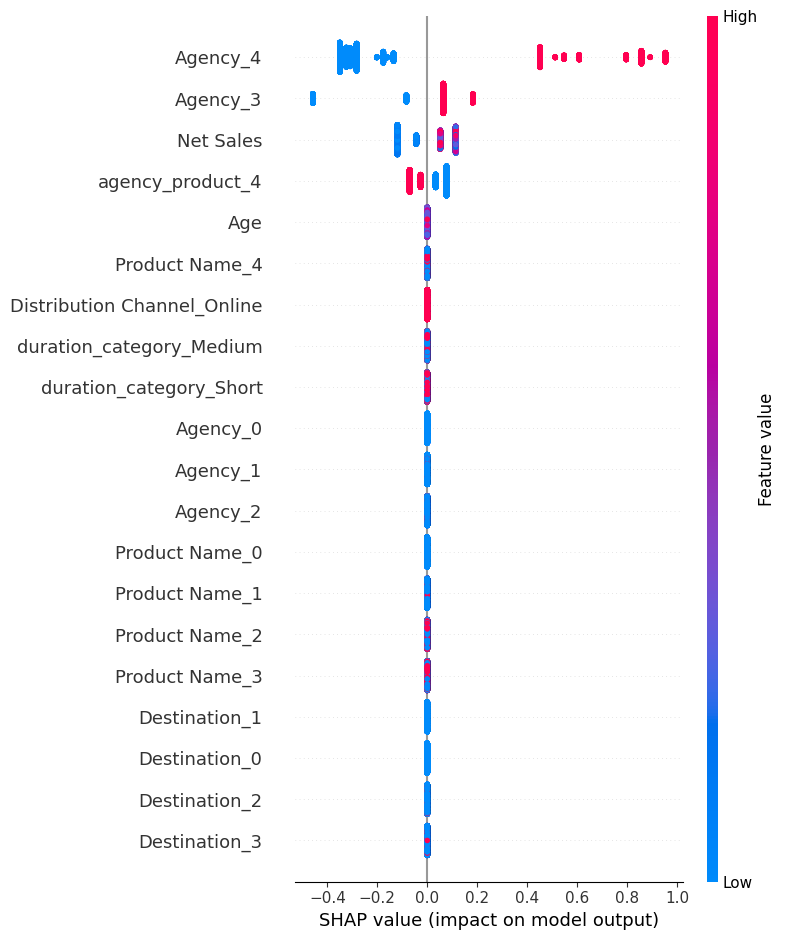

In [205]:
# Mengubah sparse matrix menjadi array hasil dari OHE
model_shap = model_tuning
model_shap.set_params(transformer__ohe__sparse_output=False)
model_shap.set_output(transform="pandas")

# fit model shap
model_shap_fit = model_shap.fit(X_train, y_train)

# Ambil komponen yang sudah di fit dari pipeline final
steps = model_shap_fit.named_steps
func_imput_fitted        = steps['func_imput']
iter_imput_fitted        = steps['iter_imput']
feature_engineering_fitted = steps['feature_engineering']
transformer_fitted       = steps['transformer']
model_fitted             = steps['model']

# Buat preprocessing only pipeline tanpa sampler & model
pipe_prep = skPipeline([
    ('func_imput',        func_imput_fitted),
    ('iter_imput',        iter_imput_fitted),
    ('feature_engineering', feature_engineering_fitted),
    ('transformer',       transformer_fitted),
])
pipe_prep.set_output(transform="pandas")

# Transform X_train
shap_data = pipe_prep.transform(X_test)
feature_names = list(shap_data.columns)

# Buat Explainer
import shap

explainer = shap.TreeExplainer(model_fitted, data=shap_data)
shap_vals = explainer.shap_values(shap_data)
shap.summary_plot(shap_vals, shap_data, feature_names=feature_names)

Berdasarkan analisis SHAP, fitur Agency (khususnya hasil binary encoding Agency_4 dan Agency_3) menunjukkan pengaruh paling besar terhadap prediksi klaim, di mana nilai tinggi pada keduanya (titik merah di kanan) cenderung meningkatkan kemungkinan klaim dan nilai rendahnya (titik biru di kiri) menurunkan kemungkinan klaim. Sedangkan Net Sales, fitur gabungan tambahan agency_product (khususnya hasil binary encoding Product Name_4) memiliki kontribusi sedang dengan arah pengaruh yang bervariasi. Sementara fitur lain seperti Age, Product Name (khususnya hasil binary encoding Product Name_4), Distribution Channel_Online, duration_category_Medium, duration_category_Short, serta mayoritas dummy binary dari agency dan product name lainnya sebagian besar berkumpul di sekitar nol yang menandakan kontribusi prediksi sangat kecil sehingga dapat dipertimbangkan untuk dihapus atau dikelompokkan ulang.

## **Conclusion & Recommendation & Limitation**

### Conclusion

In [ ]:
print('Gradient Boost Classifier Report')
print('--------------')
print(f'f2 Score: {fbeta_score(y_test, y_pred_tuning, beta=2)}')
print(confusion_matrix(y_test, y_pred_tuning))
print(classification_report(y_test, y_pred_tuning))

Gradient Boost Classifier Report
--------------
f2 Score: 0.23486134691567628
[[6520 1144]
 [  52   83]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7664
           1       0.07      0.61      0.12       135

    accuracy                           0.85      7799
   macro avg       0.53      0.73      0.52      7799
weighted avg       0.98      0.85      0.90      7799



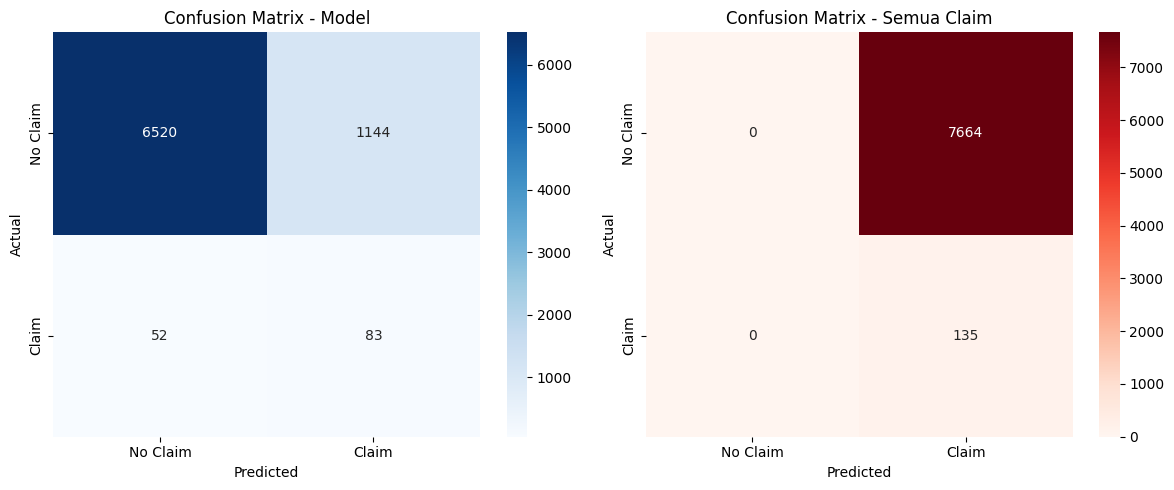

In [207]:
# 1. Confusion Matrix hasil Model
cm_model = confusion_matrix(y_test, y_pred_tuning)

# 2. Confusion Matrix All Claim
y_pred_all_claim = np.ones_like(y_test)  # semua prediksi = 1
cm_all_claim = confusion_matrix(y_test, y_pred_all_claim)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap 1: Model
sns.heatmap(cm_model, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Claim", "Claim"],
            yticklabels=["No Claim", "Claim"],
            ax=axes[0])
axes[0].set_title("Confusion Matrix - Model")
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")

# Heatmap 2: Confusion Matrix All Claim
sns.heatmap(cm_all_claim, annot=True, fmt="d", cmap="Reds",
            xticklabels=["No Claim", "Claim"],
            yticklabels=["No Claim", "Claim"],
            ax=axes[1])
axes[1].set_title("Confusion Matrix - Semua Claim")
axes[1].set_ylabel("Actual")
axes[1].set_xlabel("Predicted")

plt.tight_layout()
plt.show()

Berdasarkan hasil confusion matrix dari model Gradient Boost Classifier, dapat disimpulkan bahwa jika model ini digunakan untuk memfilter nasabah yang akan dilakukan pemeriksaan klaim, maka model mampu menghindari pemeriksaan pada sebagian besar nasabah yang tidak mengajukan klaim (recall kelas 0 = 85%) sehingga berpotensi menghemat biaya pengecekan, sambil tetap menangkap sebagian besar nasabah yang benar-benar mengajukan klaim (recall kelas 1 = 61%). Namun konsekuensinya adalah tingkat ketepatan prediksi klaim masih rendah (precision kelas 1 = 7%) yang mengakibatkan kurang tepatnya penilaian dalam menentukan premi nantinya yang dapat mengakibatkan nasabah berpindah pada kompetitor lain.

Oleh karena itu, meskipun model ini dapat memberikan manfaat dengan mampu menilai banyak kandidat yang kemungkinan mengajukan claim, namun perlu mempertimbangkan trade-off dengan tidak terdeteksinya nasabah yang kemungkinan tidak akan klaim. Untuk skenario yang sudah kita sampaikan di awal bahwa cost yang ditimbulkan untuk nasabah yang benar-benar mengajukan klaim namun tidak terdeteksi (FN) adalah USD 305 dan nasabah yang tidak mengajukan klaim namun di prediksi akan mengajukan klaim (FP) adalah USD 100, maka hitungannya kurang lebih akan seperti ini:

Tanpa Model (Semua nasabah diangggap Claim)
- Nasabah yang diprediksi claim namun tidak claim (FP)= 7664 nasabah
- Cost yang ditimbulkan untuk mencari nasabah baru jika nasabah beralih ke kompetitor (FP) = USD 100
- Total Cost -> 7.664 × 100 USD = USD 766,400

Dengan Model (memeriksa hanya prediksi klaim)
- Nasabah yang diprediksi claim namun tidak claim (FP)= 1144
- Nasabah yang diprediksi tidak claim namun claim (FN)= 52
- Cost yang ditimbulkan untuk mencari nasabah baru jika nasabah beralih ke kompetitor (FP) = USD 100
- Cost yang ditimbulkan untuk membayar claim (FN) = USD 350
- Cost False Positive (FP) = 1,144 × USD 100 = USD 114,400
- Cost False Negative (FN) = 52 × USD 350 = USD 18,200
- Total Cost -> USD 114,400 + USD 18,200 = USD 114,400 

Total cost yang dikeluarkan berbeda jauh setelah menggunakan model, sesilih diantara keduanya adalah USD 652,000. Selisih ini dapat di proyeksikan sebagai keuntungan perusahaan jika memprediksi menggunakan model dibandingkan dengan yang tidak.


### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya agar lebih baik lagi:
- Memastikan kelengkapan data pada semua entitas nasabah, misalnya jika ada kolom yang kosong seperti Net Sales atau Duration, diisi dengan informasi pengganti yang relevan daripada dibiarkan kosong.
- Menambah baris data untuk nasabah yang claim agar model dapat memahami lebih baik karakteristik nasabah yang claim.
- Menambahkan fitur baru yang berpotensi relevan terhadap klaim, seperti riwayat jumlah perjalanan sebelumnya.
- Mencoba algoritma machine learning lain yang mungkin hasilnya akan lebih baik jika dilakukan tuning.
- Melakukan hyperparameter tuning lanjutan dan membandingkan beberapa teknik oversampling (SMOTE, SMOTENC, ADASYN) dan undersampling.
- Menganalisis data yang salah diprediksi (false positive dan false negative) untuk memahami pola kesalahan model dan melakukan perbaikan fitur.

### Limitation

Limitasi Model:
- Imbalance Data – Distribusi klaim (class 1) jauh lebih sedikit dibandingkan non-klaim (class 0), sehingga model cenderung bias memprediksi class mayoritas.
- F2 Score Tinggi Karena Recall – Nilai F2 yang baik terutama didorong oleh recall tinggi, namun precision rendah, sehingga potensi false positive masih besar.
- Fitur Tidak Informatif – Beberapa fitur memiliki kontribusi kecil berdasarkan analisis feature importance, sehingga model mungkin terpengaruh noise.
- Keterbatasan Informasi Fitur – Data yang digunakan mungkin belum mencakup variabel penting lain yang berpengaruh pada perilaku klaim, seperti histori transaksi lengkap, profil pelanggan lebih detail, atau faktor eksternal.
- Kesensitifan Terhadap Perubahan Data – Jika distribusi data berubah (misalnya perubahan tren klaim), performa model bisa menurun tanpa retraining.

##
---

## **Additional**

**Melatih Model ke semua data yang ada dan memprediksikannya ke dummy data**

In [213]:
final_model = model_tuning
final_model_fit = final_model.fit(X, y)
final_model_fit

/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('func_imput',
                 FunctionTransformer(func=<function <lambda> at 0x17ee56d40>)),
                ('iter_imput',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_iter',
                                                  IterativeImputer(random_state=42),
                                                  ['Duration', 'Net Sales',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('feature_engineering',
                 FunctionTransformer(func=<function feature_engineer at 0x17...
                                                   'duration_category']),
                                                 ('bin', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination',
                                                   'agency_product']),
                                                 ('num', RobustScaler(),
                                                  ['Duration', 'Net Sales',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomOverSampler(random_state=42)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.008, max_depth=2,
                                            min_samples_leaf=4,
                                            min_samples_split=4,
                                            random_state=42))])

In [221]:
df_dummy = pd.read_csv('data_travel_insurance_dummy.csv')

X_dummy = df_dummy.drop(columns='Claim')
y_dummy = df_dummy['Claim'].map({'No': 0, 'Yes': 1})

display(X_dummy.head())
display(y_dummy.head())

Agency    Agency Type Distribution Channel                     Product Name  \
0    CSR       Airlines              Offline                Cancellation Plan   
1    SSI       Airlines              Offline                 Annual Gold Plan   
2    CWT  Travel Agency              Offline                      Silver Plan   
3    CBH  Travel Agency              Offline  Rental Vehicle Excess Insurance   
4    JWT  Travel Agency               Online         2 way Comprehensive Plan   

   Duration         Destination  Net Sales  Age  
0       235               BENIN       5.35   28  
1       284             BELGIUM      58.50   38  
2       112            BOTSWANA       5.27   67  
3       275  KOREA, REPUBLIC OF     336.50   46  
4       408   BRUNEI DARUSSALAM     108.00   55

0    0
1    1
2    1
3    0
4    1
Name: Claim, dtype: int64

In [223]:
y_pred_dummy = final_model_fit.predict(X_dummy)

print(f'f2 score:', fbeta_score(y_dummy, y_pred_dummy, beta=2))
print(confusion_matrix(y_dummy, y_pred_dummy))
print(classification_report(y_dummy, y_pred_dummy))

f2 score: 0.46218487394957986
[[17  8]
 [14 11]]
              precision    recall  f1-score   support

           0       0.55      0.68      0.61        25
           1       0.58      0.44      0.50        25

    accuracy                           0.56        50
   macro avg       0.56      0.56      0.55        50
weighted avg       0.56      0.56      0.55        50



/Users/primade/Library/Python/3.13/lib/python/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros



Hasil prediksi memiliki f2_score yang cukup baik, dengan recall yang turun namun precision naik. Model terlihat bisa lebih baik dalam menemukan pola dengan data training lebih banyak.